In [68]:
import json
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [338]:
df = pd.read_csv('rawdata/catastici_1740.csv')
gdf = gpd.read_file('rawdata/catastici_1740_full_geojson_20240917.geojson')
district_gdf = gpd.read_file('rawdata/1740_redrawn_parishes_cleaned_wikidata_standardised.geojson')

In [339]:
df['category'] = 'Unknown/Other'
df.loc[df['function'].str.contains('casa|appartamento|casetta', case=False, na=False), 'category'] = 'Property (Houses/Real Estate)'
df.loc[df['function'].str.contains('bottega|magazen', case=False, na=False), 'category'] = 'Commerce/Retail'
df.loc[df['function'].str.contains('casa e bottega', case=False, na=False), 'category'] = 'Mixed Use (Residential + Commerce)'
df.loc[df['function'].str.contains('chiesa|religious|institution', case=False, na=False), 'category'] = 'Religious/Institutional'
df.loc[df['function'].str.contains('magazzino|storage', case=False, na=False), 'category'] = 'Religious/Institutional'
df.loc[df['function'].str.contains('libert|squero|gondola', case=False, na=False), 'category'] = 'Traghetto/Squero'
gdf['category'] = 'Unknown/Other'
gdf.loc[gdf['function'].str.contains('casa|appartamento|casetta', case=False, na=False), 'category'] = 'Residential'
gdf.loc[gdf['function'].str.contains('bottega|magazen', case=False, na=False), 'category'] = 'Commerce/Retail'
gdf.loc[gdf['function'].str.contains('casa e bottega', case=False, na=False), 'category'] = 'Mixed Use'
gdf.loc[gdf['function'].str.contains('chiesa|religious|institution', case=False, na=False), 'category'] = 'Religious'
gdf.loc[gdf['function'].str.contains('magazzino|storage', case=False, na=False), 'category'] = 'Religious'
gdf.loc[gdf['function'].str.contains('libert|squero|gondola', case=False, na=False), 'category'] = 'Traghetto'

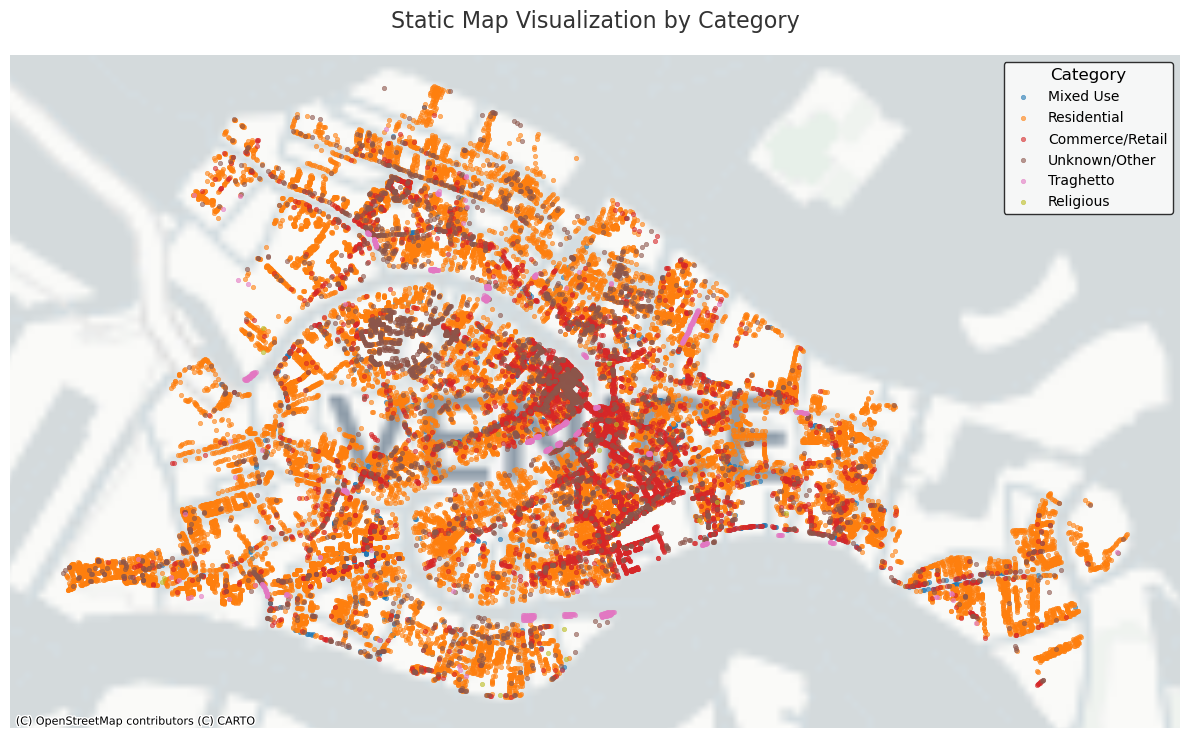

In [340]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_hex
import geopandas as gpd
import contextily as ctx

# Assumed: gdf is your GeoDataFrame containing 'geometry' and 'category'

# 1. Define the color mapping for categories
categories = gdf['category'].unique()
color_map = {cat: cm.tab10(i / len(categories)) for i, cat in enumerate(categories)}

# 2. Convert to Web Mercator (for compatibility with basemap)
gdf = gdf.to_crs(epsg=3857)
# 3. Initialize the figure
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figure size for aesthetics

# 4. Plot points on the map
for cat in categories:
    subset = gdf[gdf['category'] == cat]
    subset.plot(
        ax=ax,
        color=to_hex(color_map[cat]),
        markersize=10,  # Adjust marker size
        label=cat,
        alpha=0.6,
        #edgecolor="white",  # Adds a clean outline to the points
        linewidth=0.5
    )

# 5. Add the basemap (CartoDB Positron)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

# 6. Customize the legend
legend = ax.legend(
    title="Category",
    loc="upper right",
    frameon=True,
    fontsize=10,
    title_fontsize=12,
    facecolor="white",
    edgecolor="black"
)
legend.get_frame().set_alpha(0.8)  # Slightly transparent legend box

# 7. Clean up the plot appearance
ax.set_title("Static Map Visualization by Category", fontsize=16, pad=20, color="#333333")
ax.axis('off')  # Remove axes for a clean look

# 8. Save and show the map
plt.tight_layout()
#plt.savefig("enhanced_static_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [73]:
gdf = gdf.to_crs(epsg=4326)

In [74]:
owner_df = gdf[gdf['owner_name'].notna()].copy()
owner_df = owner_df[owner_df['owner_name']!= 'nan']
owner_df['person'] = owner_df['owner_name']
owner_df['role'] = 'owner'

tenant_df = gdf[gdf['ten_name'].notna()].copy()
tenant_df = tenant_df[tenant_df['ten_name']!= 'nan']
tenant_df['person'] = tenant_df['ten_name']
tenant_df['role'] = 'tenant'

combined_df = pd.concat([owner_df, tenant_df], ignore_index=True)
properties_with_tenant = gdf[gdf['ten_name'].notna()]['geometry'].unique()
owner_df_filtered = owner_df[~owner_df['geometry'].isin(properties_with_tenant)]
combined_df_filtered = pd.concat([owner_df_filtered, tenant_df], ignore_index=True)
person_group = combined_df_filtered.groupby('person').size().reset_index(name='count')

multi_property_persons = person_group[person_group['count'] > 1]
multi_property_details = combined_df_filtered[combined_df_filtered['person'].isin(multi_property_persons['person'])]

multi_property_details = multi_property_details.copy()

residential = multi_property_details[multi_property_details['category'] == 'Property (Houses/Real Estate)']
non_residential = multi_property_details[multi_property_details['category'] != 'Property (Houses/Real Estate)']

results = []

for person in multi_property_details['person'].unique():
    # Get the work place and home place
    person_residential = residential[residential['person'] == person]
    person_non_residential = non_residential[non_residential['person'] == person]
    
    # If an agent has work place and home place at the same time, make a pair
    for _, home in person_residential.iterrows():
        for _, work in person_non_residential.iterrows():
            results.append({
                'person': person,
                'home_location': home['geometry'],
                'work_location': work['geometry'],
                'home_role': home['role'],  # owner or tenant
                'work_role': work['role'],  # owner or tenant
                'home_function': home['category'],
                'work_function': work['category']
            })

results_df = pd.DataFrame(results)

results_df.head

<bound method NDFrame.head of                        person                                  home_location  \
0               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
1               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
2               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
3               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
4               Carlo Altieri   POINT (12.323284217778234 45.43653853599313)   
...                       ...                                            ...   
3468           Gasparo Fratta  POINT (12.327032201418056 45.436617285111886)   
3469      Francesco Melchioni   POINT (12.330910829658587 45.43866510660604)   
3470           Lauro Buffelli   POINT (12.331169159903622 45.43866393487573)   
3471  Giambattista Cristofoli   POINT (12.332570366764477 45.43838894360294)   
3472          Bernardo Donini    POINT (12.33331411544795 45.43823229357393)   

         

In [343]:
import geopandas as gpd
from shapely.wkt import loads
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# results_df is a geopandas dataframe and we need to link between home_location and work_location
district_gdf = gpd.read_file('rawdata/venice1740_parishes_processed.geojson')

# Construct LineString geometry
od_gdf = results_df.copy()
od_gdf['od_line'] = od_gdf.apply(
    lambda row: LineString([row['home_location'], row['work_location']]), axis=1
)

od_gdf = gpd.GeoDataFrame(od_gdf, geometry='od_line', crs="EPSG:4326")

In [344]:
od_gdf.head()

person                                 home_location  \
0  Carlo Altieri   POINT (12.338264035522352 45.4401761930241)   
1  Carlo Altieri   POINT (12.338264035522352 45.4401761930241)   
2  Carlo Altieri   POINT (12.338264035522352 45.4401761930241)   
3  Carlo Altieri   POINT (12.338264035522352 45.4401761930241)   
4  Carlo Altieri  POINT (12.323284217778234 45.43653853599313)   

                                  work_location home_role work_role  \
0  POINT (12.336942815970918 45.43817682121253)    tenant    tenant   
1  POINT (12.336997654111373 45.43837569554335)    tenant    tenant   
2   POINT (12.337007034538326 45.4384037283432)    tenant    tenant   
3  POINT (12.337008052173184 45.43841707959555)    tenant    tenant   
4  POINT (12.336942815970918 45.43817682121253)    tenant    tenant   

                   home_function    work_function  \
0  Property (Houses/Real Estate)  Commerce/Retail   
1  Property (Houses/Real Estate)    Unknown/Other   
2  Property (Houses/Real Estate)  Commerce/Retail   
3  Property (Houses/Real Estate)  Commerce/Retail   
4  Property (Houses/Real Estate)  Commerce/Retail   

                                             od_line  
0  LINESTRING (12.33826 45.44018, 12.33694 45.43818)  
1    LINESTRING (12.33826 45.44018, 12.337 45.43838)  
2   LINESTRING (12.33826 45.44018, 12.33701 45.4384)  
3  LINESTRING (12.33826 45.44018, 12.33701 45.43842)  
4  LINESTRING (12.32328 45.43654, 12.33694 45.43818)

In [345]:
district_gdf.head()

NAME           alt_name  id    SESTIERE  \
0     Ghetto Vecchio     Ghetto Vecchio  75  Cannaregio   
1       Ghetto Nuovo       Ghetto Nuovo  74  Cannaregio   
2  Ghetto Nuovissimo  Ghetto Nuovissimo  73  Cannaregio   
3       San Marcuola        S. Marcuola   4  Cannaregio   
4        San Lunardo        S. Leonardo   3  Cannaregio   

                                    church      wd_venetian_name  \
0                                     None                  None   
1                                     None                  None   
2                                     None                  None   
3  http://www.wikidata.org/entity/Q1585514  Céxa de San Marcuoła   
4  http://www.wikidata.org/entity/Q3585356                  None   

          wd_italian_name side_canal  \
0                    None       east   
1                    None       east   
2                    None       east   
3  chiesa di San Marcuola       east   
4  chiesa di San Leonardo       east   

                                            geometry  
0  POLYGON ((12.32468 45.44424, 12.32508 45.44404...  
1  POLYGON ((12.32608 45.44544, 12.32643 45.4459,...  
2  POLYGON ((12.3273 45.44503, 12.32747 45.4449, ...  
3  POLYGON ((12.32707 45.44492, 12.32736 45.44431...  
4  POLYGON ((12.32698 45.44264, 12.32619 45.44262...

In [346]:
results_df

person                                  home_location  \
0               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
1               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
2               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
3               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
4               Carlo Altieri   POINT (12.323284217778234 45.43653853599313)   
...                       ...                                            ...   
3468           Gasparo Fratta  POINT (12.327032201418056 45.436617285111886)   
3469      Francesco Melchioni   POINT (12.330910829658587 45.43866510660604)   
3470           Lauro Buffelli   POINT (12.331169159903622 45.43866393487573)   
3471  Giambattista Cristofoli   POINT (12.332570366764477 45.43838894360294)   
3472          Bernardo Donini    POINT (12.33331411544795 45.43823229357393)   

                                      work_location home_role work_role  \
0      POINT (12.336942815970918 45.43817682121253)    tenant    tenant   
1      POINT (12.336997654111373 45.43837569554335)    tenant    tenant   
2       POINT (12.337007034538326 45.4384037283432)    tenant    tenant   
3      POINT (12.337008052173184 45.43841707959555)    tenant    tenant   
4      POINT (12.336942815970918 45.43817682121253)    tenant    tenant   
...                                             ...       ...       ...   
3468   POINT (12.327020953977279 45.43655447133941)    tenant    tenant   
3469  POINT (12.331085274322898 45.438133000516714)    tenant    tenant   
3470  POINT (12.331227354432839 45.438644156419834)    tenant    tenant   
3471   POINT (12.332586366649776 45.43840504907394)    tenant    tenant   
3472   POINT (12.333327643395583 45.43821196201631)    tenant    tenant   

                      home_function    work_function  
0     Property (Houses/Real Estate)  Commerce/Retail  
1     Property (Houses/Real Estate)    Unknown/Other  
2     Property (Houses/Real Estate)  Commerce/Retail  
3     Property (Houses/Real Estate)  Commerce/Retail  
4     Property (Houses/Real Estate)  Commerce/Retail  
...                             ...              ...  
3468  Property (Houses/Real Estate)    Unknown/Other  
3469  Property (Houses/Real Estate)  Commerce/Retail  
3470  Property (Houses/Real Estate)    Unknown/Other  
3471  Property (Houses/Real Estate)    Unknown/Other  
3472  Property (Houses/Real Estate)  Commerce/Retail  

[3473 rows x 7 columns]

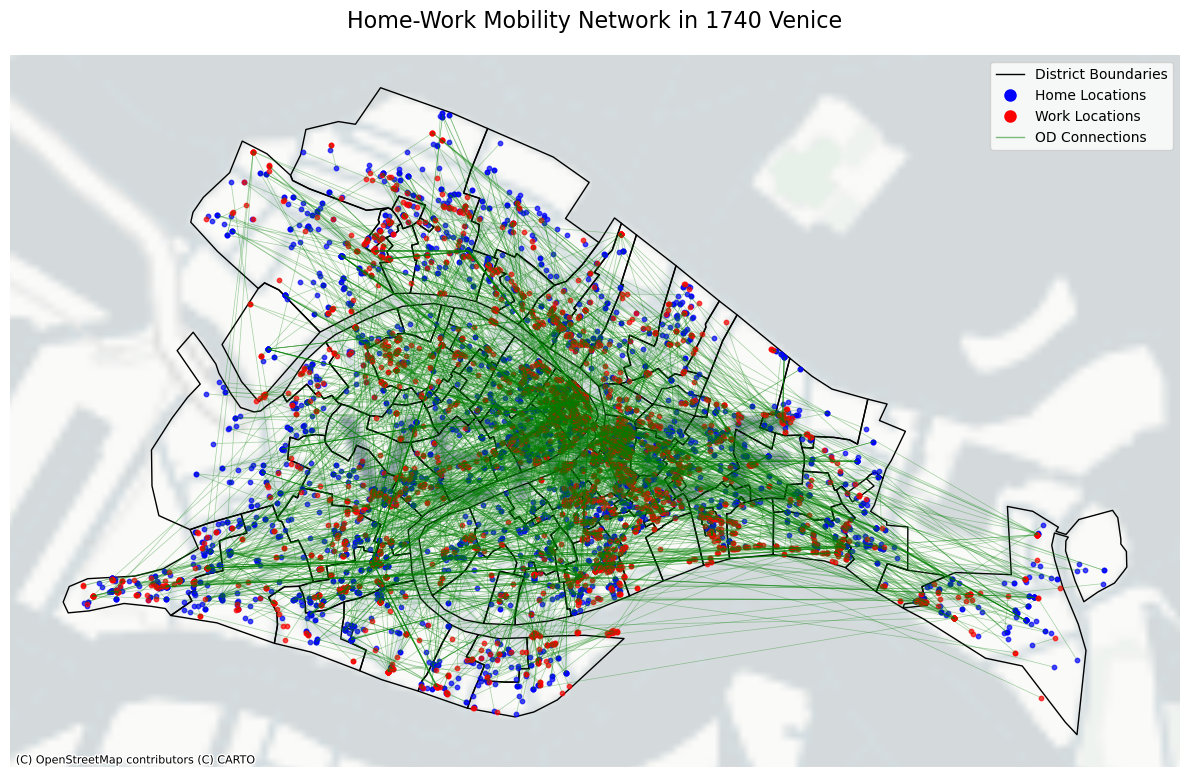

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  
from shapely.geometry import Point
from matplotlib.lines import Line2D

results_gdf_home_plot = gpd.GeoDataFrame(results_df.copy(), geometry='home_location', crs="EPSG:4326")
results_gdf_work_plot = gpd.GeoDataFrame(results_df.copy(), geometry='work_location', crs="EPSG:4326")
district_gdf_plot = district_gdf.copy()
od_gdf_plot = od_gdf.copy()

results_gdf_home_plot = results_gdf_home_plot.to_crs(epsg=3857)
results_gdf_work_plot = results_gdf_work_plot.to_crs(epsg=3857)
district_gdf_plot = district_gdf_plot.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))  

district_gdf_plot.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label="Districts")

results_gdf_home_plot.plot(ax=ax, color='blue', markersize=10, alpha=0.7, label="Home Locations")
results_gdf_work_plot.plot(ax=ax, color='red', markersize=10, alpha=0.7, label="Work Locations")

for _, row in od_gdf_plot.iterrows():
    home_point = Point(row['home_location'].x, row['home_location'].y)
    work_point = Point(row['work_location'].x, row['work_location'].y)
    home_projected = gpd.GeoSeries([home_point], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]
    work_projected = gpd.GeoSeries([work_point], crs="EPSG:4326").to_crs(epsg=3857).iloc[0]
    ax.plot(
        [home_projected.x, work_projected.x],
        [home_projected.y, work_projected.y],
        color='green',
        linewidth=0.5,
        alpha=0.35
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)

legend_elements = [
    Line2D([0], [0], color='black', lw=1, label='District Boundaries'),
    Line2D([0], [0], marker='o', color='blue', markersize=8, linestyle='None', label='Home Locations'),
    Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='None', label='Work Locations'),
    Line2D([0], [0], color='green', lw=1, alpha=0.5, label='OD Connections')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_title("Home-Work Mobility Network in 1740 Venice", fontsize=16, pad=20)
ax.axis('off') 

plt.tight_layout()
plt.show()

In [348]:
import geopandas as gpd
import pandas as pd

orig = od_gdf.copy()
orig["orig_idx"] = orig.index
orig = orig.set_geometry("home_location")
join_o = gpd.sjoin(orig, district_gdf[["NAME","geometry"]],
                   how="left", predicate="within")

home_zone = (join_o
             .groupby("orig_idx", as_index=True)["NAME"]
             .first()
             .rename("home_zone"))

dest = od_gdf.copy()
dest["orig_idx"] = dest.index
dest = dest.set_geometry("work_location")
join_d = gpd.sjoin(dest, district_gdf[["NAME","geometry"]],
                   how="left", predicate="within")

work_zone = (join_d
             .groupby("orig_idx", as_index=True)["NAME"]
             .first()
             .rename("work_zone"))

od_zones = pd.concat([home_zone, work_zone], axis=1)

od_matrix = (od_zones
             .groupby(["home_zone","work_zone"], dropna=False)
             .size()
             .reset_index(name="trips"))
od_matrix.head()

home_zone          work_zone  trips
0  Ghetto Nuovissimo  Ghetto Nuovissimo      1
1  Ghetto Nuovissimo       Ghetto Nuovo      1
2       Ghetto Nuovo  Ghetto Nuovissimo      1
3       Ghetto Nuovo       Ghetto Nuovo     12
4     Ghetto Vecchio       Ghetto Nuovo      1

In [355]:
# Load your district GeoDataFrame
district_gdf = gpd.read_file('rawdata/venice1740_parishes_processed.geojson')
district_gdf = district_gdf[district_gdf['NAME'] != "Sant'Eufemia"]
district_gdf.head()
district_gdf

NAME           alt_name  id    SESTIERE  \
0      Ghetto Vecchio     Ghetto Vecchio  75  Cannaregio   
1        Ghetto Nuovo       Ghetto Nuovo  74  Cannaregio   
2   Ghetto Nuovissimo  Ghetto Nuovissimo  73  Cannaregio   
3        San Marcuola        S. Marcuola   4  Cannaregio   
4         San Lunardo        S. Leonardo   3  Cannaregio   
..                ...                ...  ..         ...   
70        San Barnaba         S. Barnaba  35   Dorsoduro   
71        San Trovaso         S. Trovaso  31   Dorsoduro   
72        Sant'Agnese          S. Agnese  72   Dorsoduro   
73            San Vio             S. Vio  29   Dorsoduro   
74       San Gregorio        S. Gregorio  28   Dorsoduro   

                                     church      wd_venetian_name  \
0                                      None                  None   
1                                      None                  None   
2                                      None                  None   
3   http://www.wikidata.org/entity/Q1585514  Céxa de San Marcuoła   
4   http://www.wikidata.org/entity/Q3585356                  None   
..                                      ...                   ...   
70  http://www.wikidata.org/entity/Q2356961   Céxa de San Barnaba   
71  http://www.wikidata.org/entity/Q1129555   Céxa de San Trovaso   
72  http://www.wikidata.org/entity/Q2929832                  None   
73  http://www.wikidata.org/entity/Q3672175                  None   
74  http://www.wikidata.org/entity/Q3670710  Céxa de San Gregorio   

           wd_italian_name side_canal  \
0                     None       east   
1                     None       east   
2                     None       east   
3   chiesa di San Marcuola       east   
4   chiesa di San Leonardo       east   
..                     ...        ...   
70   chiesa di San Barnaba       west   
71   chiesa di San Trovaso       west   
72   chiesa di Sant'Agnese       west   
73       chiesa di San Vio       west   
74  chiesa di San Gregorio       west   

                                             geometry  
0   POLYGON ((12.32468 45.44424, 12.32508 45.44404...  
1   POLYGON ((12.32608 45.44544, 12.32643 45.4459,...  
2   POLYGON ((12.3273 45.44503, 12.32747 45.4449, ...  
3   POLYGON ((12.32707 45.44492, 12.32736 45.44431...  
4   POLYGON ((12.32698 45.44264, 12.32619 45.44262...  
..                                                ...  
70  POLYGON ((12.3238 45.43223, 12.3245 45.43235, ...  
71  POLYGON ((12.32715 45.43295, 12.32571 45.43273...  
72  POLYGON ((12.32735 45.42922, 12.3281 45.42904,...  
73  POLYGON ((12.33023 45.43113, 12.33093 45.43103...  
74  POLYGON ((12.33027 45.42961, 12.33009 45.42934...  

[75 rows x 9 columns]

In [ ]:
def make_unique_names(names):
    """Add suffix to duplicate names to make all names unique."""
    from collections import defaultdict
    counter = defaultdict(int)
    unique_names = []
    for name in names:
        counter[name] += 1
        if counter[name] == 1:
            unique_names.append(name)
        else:
            unique_names.append(f"{name}_{counter[name]}")
    return unique_names

district_gdf['NAME'] = make_unique_names(district_gdf['NAME'])

In [358]:
# Venice District Adjacency Matrix Creation
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


# For demonstration, let's assume you have district_gdf loaded
print("Creating adjacency matrix for Venice districts...")

# Create adjacency matrix using Queen contiguity (shared boundary/corner)
def create_adjacency_matrix(gdf):
    """
    Create adjacency matrix based on Queen contiguity
    Returns: adjacency matrix (pandas DataFrame)
    """
    n_districts = len(gdf)
    adjacency_matrix = np.zeros((n_districts, n_districts), dtype=int)
    
    # Get district names for indexing
    district_names = gdf['NAME'].tolist()
    
    print(f"Processing {n_districts} districts...")
    
    for i in range(n_districts):
        for j in range(n_districts):
            if i != j:  # Don't compare district with itself
                # Check if districts share boundary (Queen contiguity)
                geom_i = gdf.iloc[i].geometry
                geom_j = gdf.iloc[j].geometry
                
                # Districts are adjacent if they touch (share boundary or corner)
                if geom_i.touches(geom_j):
                    adjacency_matrix[i, j] = 1
                    print(f"Adjacent: {district_names[i]} <-> {district_names[j]}")
    
    # Convert to DataFrame for easier handling
    adj_df = pd.DataFrame(adjacency_matrix, 
                         index=district_names, 
                         columns=district_names)
    
    return adj_df

# Create the adjacency matrix
# adjacency_matrix = create_adjacency_matrix(district_gdf)

# Alternative method using libpysal for more robust spatial relationships
try:
    import libpysal as lps
    
    def create_adjacency_libpysal(gdf):
        """
        Alternative method using libpysal for spatial weights
        """
        # Create Queen contiguity weights
        w_queen = lps.weights.Queen.from_dataframe(gdf)
        
        # Convert to adjacency matrix
        adj_matrix = w_queen.full()[0]  # Get the full adjacency matrix
        district_names = gdf['NAME'].tolist()
        
        adj_df = pd.DataFrame(adj_matrix,
                             index=district_names,
                             columns=district_names)
        return adj_df
    
    print("Using libpysal method (recommended)...")
    # adjacency_matrix = create_adjacency_libpysal(district_gdf)
    
except ImportError:
    print("libpysal not installed. Using basic method...")
    # Use the basic method above

# Display adjacency matrix info
print("\nAdjacency Matrix created!")
print("Matrix shape:", adjacency_matrix.shape if 'adjacency_matrix' in locals() else "Run with actual data")
print("Total connections:", adjacency_matrix.sum().sum() if 'adjacency_matrix' in locals() else "Run with actual data")

# Visualize the network connections
def visualize_network(gdf, adj_matrix):
    """
    Visualize the district network with connections (no text labels).
    """
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    
    # Plot district polygons
    gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.7)
    
    # Get centroids for connecting lines and plotting nodes
    centroids = gdf.geometry.centroid
    
    # Draw network links
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):  # Only upper triangle to avoid duplicates
            if adj_matrix.iloc[i, j] == 1:
                x_coords = [centroids.iloc[i].x, centroids.iloc[j].x]
                y_coords = [centroids.iloc[i].y, centroids.iloc[j].y]
                ax.plot(x_coords, y_coords, 'r-', alpha=0.5, linewidth=1.3)
    
    # Draw nodes as black dots
    ax.scatter(centroids.x, centroids.y, color='k', s=40, zorder=3)

    ax.set_title('Venice Districts Network - Nodes and Links')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.axis('off')  # Optional: remove axis

    return fig, ax
print("\nTo use this code:")
print("1. Load your district_gdf")
print("2. Run create_adjacency_matrix(district_gdf)")
print("3. Use visualize_network(district_gdf, adjacency_matrix) to see connections")


Creating adjacency matrix for Venice districts...
Using libpysal method (recommended)...

Adjacency Matrix created!
Matrix shape: (72, 72)
Total connections: 290

To use this code:
1. Load your district_gdf
2. Run create_adjacency_matrix(district_gdf)
3. Use visualize_network(district_gdf, adjacency_matrix) to see connections


In [359]:
# Simple buffer-based adjacency detection
import pandas as pd
import numpy as np

# Set buffer size (adjust this if needed)
buffer_size = 5e-5  # You can try 0.0005, 0.001, or 0.002

#print(f"Using buffer size: {buffer_size}")
#print("Creating buffered geometries...")

# Create buffered version of geometries
district_gdf['geometry_buffered'] = district_gdf.geometry.buffer(buffer_size)

# Get district names
district_names = district_gdf['NAME'].tolist()
n_districts = len(district_names)

#print(f"Checking adjacency for {n_districts} districts...")

# Initialize adjacency matrix
adjacency_matrix = np.zeros((n_districts, n_districts), dtype=int)

# Check adjacency using buffered geometries
for i in range(n_districts):
    for j in range(i+1, n_districts):
        # Check if buffered geometry i intersects with original geometry j
        if district_gdf.iloc[i]['geometry_buffered'].intersects(district_gdf.iloc[j].geometry):
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1
            #print(f"Adjacent: {district_names[i]} <-> {district_names[j]}")

# Convert to DataFrame
adjacency_df = pd.DataFrame(adjacency_matrix, 
                           index=district_names, 
                           columns=district_names)

#print(f"\nTotal connections found: {adjacency_matrix.sum()}")
#print(f"Adjacency matrix shape: {adjacency_df.shape}")

# Show the adjacency matrix
#print("\nAdjacency Matrix:")
adjacency_df

Ghetto Vecchio  Ghetto Nuovo  Ghetto Nuovissimo  \
Ghetto Vecchio                  0             1                  0   
Ghetto Nuovo                    1             0                  1   
Ghetto Nuovissimo               0             1                  0   
San Marcuola                    1             1                  1   
San Lunardo                     1             1                  0   
...                           ...           ...                ...   
San Barnaba                     0             0                  0   
San Trovaso                     0             0                  0   
Sant'Agnese                     0             0                  0   
San Vio                         0             0                  0   
San Gregorio                    0             0                  0   

                   San Marcuola  San Lunardo  San Geremia  Santa Lucia  \
Ghetto Vecchio                1            1            1            0   
Ghetto Nuovo                  1            1            0            0   
Ghetto Nuovissimo             1            0            0            0   
San Marcuola                  0            1            1            0   
San Lunardo                   1            0            1            0   
...                         ...          ...          ...          ...   
San Barnaba                   0            0            0            0   
San Trovaso                   0            0            0            0   
Sant'Agnese                   0            0            0            0   
San Vio                       0            0            0            0   
San Gregorio                  0            0            0            0   

                   Santa Maria Maddalena  Santa Fosca  San Marcilian  ...  \
Ghetto Vecchio                         0            0              0  ...   
Ghetto Nuovo                           0            0              0  ...   
Ghetto Nuovissimo                      0            0              0  ...   
San Marcuola                           1            1              1  ...   
San Lunardo                            0            0              0  ...   
...                                  ...          ...            ...  ...   
San Barnaba                            0            0              0  ...   
San Trovaso                            0            0              0  ...   
Sant'Agnese                            0            0              0  ...   
San Vio                                0            0              0  ...   
San Gregorio                           0            0              0  ...   

                   San Pantalon  Santa Margherita  San Nicolo  San Raffael  \
Ghetto Vecchio                0                 0           0            0   
Ghetto Nuovo                  0                 0           0            0   
Ghetto Nuovissimo             0                 0           0            0   
San Marcuola                  0                 0           0            0   
San Lunardo                   0                 0           0            0   
...                         ...               ...         ...          ...   
San Barnaba                   1                 1           0            1   
San Trovaso                   0                 0           0            0   
Sant'Agnese                   0                 0           0            0   
San Vio                       0                 0           0            0   
San Gregorio                  0                 0           0            0   

                   San Basegio  San Barnaba  San Trovaso  Sant'Agnese  \
Ghetto Vecchio               0            0            0            0   
Ghetto Nuovo                 0            0            0            0   
Ghetto Nuovissimo            0            0            0            0   
San Marcuola                 0            0            0            0   
San Lunardo                  0            0            0      

(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Venice Districts Network - Nodes and Links'}, xlabel='Longitude', ylabel='Latitude'>)

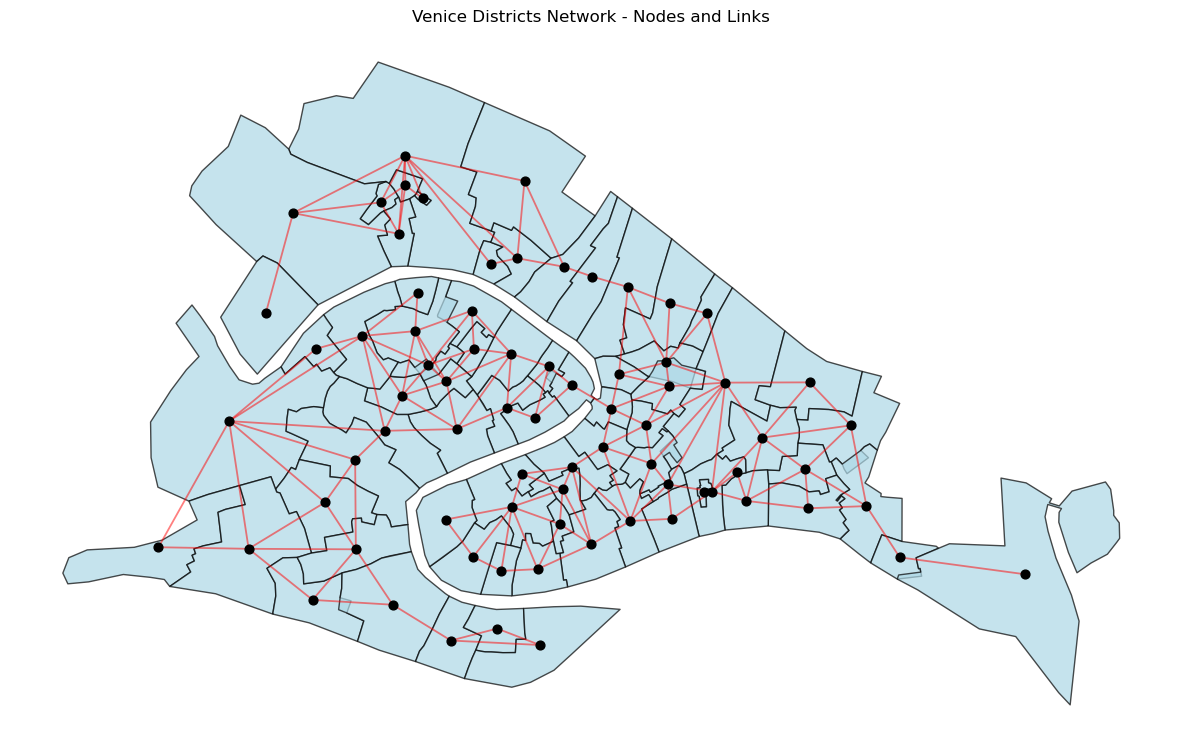

In [360]:
visualize_network(district_gdf, adjacency_df)

In [364]:
import folium

def visualize_network_interactive_folium(district_gdf, adj_matrix,
                                         start_zoom=13, tiles="CartoDB.Positron"):
    """
    Interactive map of districts + adjacency links using pure Folium primitives.
    Avoids GeoJson serialization issues by drawing Polygons, Polylines, and Markers directly.
    """
    # 1) Reproject to WGS84 and reset index
    gdf = district_gdf.to_crs(epsg=4326).reset_index(drop=True)
    centroids = gdf.geometry.centroid
    center = [centroids.y.mean(), centroids.x.mean()]
    
    # 2) Create Folium map
    m = folium.Map(location=center, zoom_start=start_zoom, tiles=tiles)
    
    # 3) Draw each district as a Polygon
    for idx, row in gdf.iterrows():
        poly = row.geometry
        # exterior ring coords
        exterior = [(lat, lon) for lon, lat in poly.exterior.coords]
        folium.Polygon(
            locations=exterior,
            color="black",
            weight=1,
            fill=True,
            fill_color="lightblue",
            fill_opacity=0.5,
            popup=row["NAME"]
        ).add_to(m)
        # if there are holes, draw them as white polygons
        for interior in poly.interiors:
            hole = [(lat, lon) for lon, lat in interior.coords]
            folium.Polygon(
                locations=hole,
                color="white",
                weight=1,
                fill=True,
                fill_color="white",
                fill_opacity=1.0
            ).add_to(m)
    
    # 4) Draw adjacency links as red lines between centroids
    n = len(gdf)
    for i in range(n):
        for j in range(i+1, n):
            if adj_matrix.iloc[i, j] == 1:
                pt_i = centroids.iloc[i]
                pt_j = centroids.iloc[j]
                folium.PolyLine(
                    locations=[(pt_i.y, pt_i.x), (pt_j.y, pt_j.x)],
                    color="red",
                    weight=2,
                    opacity=0.6
                ).add_to(m)
    
    # 5) Draw centroid markers with labels
    for idx, row in gdf.iterrows():
        c = centroids.iloc[idx]
        folium.CircleMarker(
            location=(c.y, c.x),
            radius=4,
            color="blue",
            fill=True,
            fill_opacity=0.8,
            popup=row["NAME"]
        ).add_to(m)
    
    # 6) Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Usage in a Jupyter notebook:
# m = visualize_network_interactive_folium(district_gdf, adjacency_df)
# m  # displays the interactive map

In [365]:
from geopy.distance import geodesic

# Parameters
WALKING_SPEED = 4.0  # km/h (historical walking speed)

print("Calculating link costs between adjacent districts...")

# Get district centroids
district_gdf['centroid'] = district_gdf.geometry.centroid
district_names = district_gdf['NAME'].tolist()

# Convert adjacency matrix to numpy for easier indexing
adj_array = adjacency_df.values

# Initialize cost matrix with infinity (no connection)
cost_matrix = pd.DataFrame(np.inf, index=district_names, columns=district_names)

# Set diagonal to zero (no cost to stay in same district)
np.fill_diagonal(cost_matrix.values, 0)

# Calculate costs only for adjacent districts
for i in range(len(district_names)):
    for j in range(len(district_names)):
        if adj_array[i, j] == 1:  # If districts are adjacent
            
            # Get coordinates (lat, lon)
            i_row = district_gdf.iloc[i]
            j_row = district_gdf.iloc[j]
            
            coord_i = (i_row['centroid'].y, i_row['centroid'].x)
            coord_j = (j_row['centroid'].y, j_row['centroid'].x)
            
            # Calculate distance in km
            distance_km = geodesic(coord_i, coord_j).kilometers
            
            # Calculate walking time in minutes
            walking_time = (distance_km / WALKING_SPEED) * 60
            
            cost_matrix.iloc[i, j] = walking_time

print(f"\nLink costs calculated!")
print(f"Number of finite costs: {np.isfinite(cost_matrix.values).sum() - len(district_names)}")
print(f"Average travel time: {cost_matrix[cost_matrix != np.inf].mean().mean():.1f} minutes")

Calculating link costs between adjacent districts...

Link costs calculated!
Number of finite costs: 306
Average travel time: 2.8 minutes


In [366]:
cost_matrix

Ghetto Vecchio  Ghetto Nuovo  Ghetto Nuovissimo  \
Ghetto Vecchio           0.000000      1.705366                inf   
Ghetto Nuovo             1.705366      0.000000           1.237992   
Ghetto Nuovissimo             inf      1.237992           0.000000   
San Marcuola             2.980465      1.664911           2.618048   
San Lunardo              2.045040      2.778228                inf   
...                           ...           ...                ...   
San Barnaba                   inf           inf                inf   
San Trovaso                   inf           inf                inf   
Sant'Agnese                   inf           inf                inf   
San Vio                       inf           inf                inf   
San Gregorio                  inf           inf                inf   

                   San Marcuola  San Lunardo  San Geremia  Santa Lucia  \
Ghetto Vecchio         2.980465     2.045040     5.005950          inf   
Ghetto Nuovo           1.664911     2.778228          inf          inf   
Ghetto Nuovissimo      2.618048          inf          inf          inf   
San Marcuola           0.000000     4.431644     7.130985          inf   
San Lunardo            4.431644     0.000000     6.098545          inf   
...                         ...          ...          ...          ...   
San Barnaba                 inf          inf          inf          inf   
San Trovaso                 inf          inf          inf          inf   
Sant'Agnese                 inf          inf          inf          inf   
San Vio                     inf          inf          inf          inf   
San Gregorio                inf          inf          inf          inf   

                   Santa Maria Maddalena  Santa Fosca  San Marcilian  ...  \
Ghetto Vecchio                       inf          inf            inf  ...   
Ghetto Nuovo                         inf          inf            inf  ...   
Ghetto Nuovissimo                    inf          inf            inf  ...   
San Marcuola                    7.826294     8.612253        6.92466  ...   
San Lunardo                          inf          inf            inf  ...   
...                                  ...          ...            ...  ...   
San Barnaba                          inf          inf            inf  ...   
San Trovaso                          inf          inf            inf  ...   
Sant'Agnese                          inf          inf            inf  ...   
San Vio                              inf          inf            inf  ...   
San Gregorio                         inf          inf            inf  ...   

                   San Pantalon  Santa Margherita  San Nicolo  San Raffael  \
Ghetto Vecchio              inf               inf         inf          inf   
Ghetto Nuovo                inf               inf         inf          inf   
Ghetto Nuovissimo           inf               inf         inf          inf   
San Marcuola                inf               inf         inf          inf   
San Lunardo                 inf               inf         inf          inf   
...                         ...               ...         ...          ...   
San Barnaba            5.065857          3.180032         inf      6.08076   
San Trovaso                 inf               inf         inf          inf   
Sant'Agnese                 inf               inf         inf          inf   
San Vio                     inf               inf         inf          inf   
San Gregorio                inf               inf         inf          inf   

                   San Basegio  San Barnaba  San Trovaso  Sant'Agnese  \
Ghetto Vecchio             inf          inf          inf          inf   
Ghetto Nuovo               inf          inf          inf          inf   
Ghetto Nuovissimo          inf          inf          inf          inf   
San Marcuola               inf          inf          inf          inf   
San Lunardo                inf          inf          inf      

In [367]:
od_gdf

person                                  home_location  \
0               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
1               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
2               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
3               Carlo Altieri    POINT (12.338264035522352 45.4401761930241)   
4               Carlo Altieri   POINT (12.323284217778234 45.43653853599313)   
...                       ...                                            ...   
3468           Gasparo Fratta  POINT (12.327032201418056 45.436617285111886)   
3469      Francesco Melchioni   POINT (12.330910829658587 45.43866510660604)   
3470           Lauro Buffelli   POINT (12.331169159903622 45.43866393487573)   
3471  Giambattista Cristofoli   POINT (12.332570366764477 45.43838894360294)   
3472          Bernardo Donini    POINT (12.33331411544795 45.43823229357393)   

                                      work_location home_role work_role  \
0      POINT (12.336942815970918 45.43817682121253)    tenant    tenant   
1      POINT (12.336997654111373 45.43837569554335)    tenant    tenant   
2       POINT (12.337007034538326 45.4384037283432)    tenant    tenant   
3      POINT (12.337008052173184 45.43841707959555)    tenant    tenant   
4      POINT (12.336942815970918 45.43817682121253)    tenant    tenant   
...                                             ...       ...       ...   
3468   POINT (12.327020953977279 45.43655447133941)    tenant    tenant   
3469  POINT (12.331085274322898 45.438133000516714)    tenant    tenant   
3470  POINT (12.331227354432839 45.438644156419834)    tenant    tenant   
3471   POINT (12.332586366649776 45.43840504907394)    tenant    tenant   
3472   POINT (12.333327643395583 45.43821196201631)    tenant    tenant   

                      home_function    work_function  \
0     Property (Houses/Real Estate)  Commerce/Retail   
1     Property (Houses/Real Estate)    Unknown/Other   
2     Property (Houses/Real Estate)  Commerce/Retail   
3     Property (Houses/Real Estate)  Commerce/Retail   
4     Property (Houses/Real Estate)  Commerce/Retail   
...                             ...              ...   
3468  Property (Houses/Real Estate)    Unknown/Other   
3469  Property (Houses/Real Estate)  Commerce/Retail   
3470  Property (Houses/Real Estate)    Unknown/Other   
3471  Property (Houses/Real Estate)    Unknown/Other   
3472  Property (Houses/Real Estate)  Commerce/Retail   

                                                od_line  
0     LINESTRING (12.33826 45.44018, 12.33694 45.43818)  
1       LINESTRING (12.33826 45.44018, 12.337 45.43838)  
2      LINESTRING (12.33826 45.44018, 12.33701 45.4384)  
3     LINESTRING (12.33826 45.44018, 12.33701 45.43842)  
4     LINESTRING (12.32328 45.43654, 12.33694 45.43818)  
...                                                 ...  
3468  LINESTRING (12.32703 45.43662, 12.32702 45.43655)  
3469  LINESTRING (12.33091 45.43867, 12.33109 45.43813)  
3470  LINESTRING (12.33117 45.43866, 12.33123 45.43864)  
3471  LINESTRING (12.33257 45.43839, 12.33259 45.43841)  
3472  LINESTRING (12.33331 45.43823, 12.33333 45.43821)  

[3473 rows x 8 columns]

In [368]:
# Aggregate OD pairs to district level
import pandas as pd
import geopandas as gpd

print("Aggregating OD pairs to district level...")

# Create empty lists to store results
origin_districts = []
destination_districts = []

print("Finding districts for each OD pair...")

# For each OD pair, find which districts the home and work locations belong to
for idx, row in od_gdf.iterrows():
    home_point = row['home_location']
    work_point = row['work_location']
    
    # Find home district
    home_district = None
    for dist_idx, district_row in district_gdf.iterrows():
        if district_row.geometry.contains(home_point):
            home_district = district_row['NAME']
            break
    
    # Find work district  
    work_district = None
    for dist_idx, district_row in district_gdf.iterrows():
        if district_row.geometry.contains(work_point):
            work_district = district_row['NAME']
            break
    
    origin_districts.append(home_district)
    destination_districts.append(work_district)
    
    if idx % 100 == 0:  # Progress indicator
        print(f"Processed {idx} OD pairs...")

# Add district columns to OD_gdf
od_gdf['origin_district'] = origin_districts
od_gdf['destination_district'] = destination_districts

# Remove rows where district not found
OD_gdf_clean = od_gdf.dropna(subset=['origin_district', 'destination_district'])

print(f"Original OD pairs: {len(od_gdf)}")
print(f"OD pairs with districts found: {len(OD_gdf_clean)}")

# Show sample
print("\nSample results:")
print(OD_gdf_clean[['person', 'origin_district', 'destination_district']].head(10))

Aggregating OD pairs to district level...
Finding districts for each OD pair...
Processed 0 OD pairs...
Processed 100 OD pairs...
Processed 200 OD pairs...
Processed 300 OD pairs...
Processed 400 OD pairs...
Processed 500 OD pairs...
Processed 600 OD pairs...
Processed 700 OD pairs...
Processed 800 OD pairs...
Processed 900 OD pairs...
Processed 1000 OD pairs...
Processed 1100 OD pairs...
Processed 1200 OD pairs...
Processed 1300 OD pairs...
Processed 1400 OD pairs...
Processed 1500 OD pairs...
Processed 1600 OD pairs...
Processed 1700 OD pairs...
Processed 1800 OD pairs...
Processed 1900 OD pairs...
Processed 2000 OD pairs...
Processed 2100 OD pairs...
Processed 2200 OD pairs...
Processed 2300 OD pairs...
Processed 2400 OD pairs...
Processed 2500 OD pairs...
Processed 2600 OD pairs...
Processed 2700 OD pairs...
Processed 2800 OD pairs...
Processed 2900 OD pairs...
Processed 3000 OD pairs...
Processed 3100 OD pairs...
Processed 3200 OD pairs...
Processed 3300 OD pairs...
Processed 3400

In [369]:
# Create district-level OD matrix from individual trips
print("Creating district-level OD matrix...")

# Count trips between each district pair
od_counts = OD_gdf_clean.groupby(['origin_district', 'destination_district']).size().reset_index(name='trip_count')

print(f"Unique OD pairs: {len(od_counts)}")

# Create full district-level OD matrix (including zero flows)
district_names = district_gdf['NAME'].tolist()
od_matrix = pd.DataFrame(0, index=district_names, columns=district_names)

# Fill in the trip counts
for _, row in od_counts.iterrows():
    origin = row['origin_district']
    destination = row['destination_district'] 
    trips = row['trip_count']
    od_matrix.loc[origin, destination] = trips

print(f"\nOD Matrix created!")
print(f"Total trips: {od_matrix.sum().sum()}")
print(f"Non-zero OD pairs: {(od_matrix > 0).sum().sum()}")

# Show top OD pairs
print(f"\nTop 10 OD pairs by trip volume:")
top_pairs = od_counts.sort_values('trip_count', ascending=False).head(10)
for _, row in top_pairs.iterrows():
    print(f"  {row['origin_district']} -> {row['destination_district']}: {row['trip_count']} trips")

# Show the OD matrix
print(f"\nOD Matrix shape: {od_matrix.shape}")
print("Sample of OD matrix:")
print(od_matrix.iloc[:5, :5])  # Show first 5x5 block

Creating district-level OD matrix...
Unique OD pairs: 935

OD Matrix created!
Total trips: 3418
Non-zero OD pairs: 935

Top 10 OD pairs by trip volume:
  San Bortolomio -> San Bortolomio: 150 trips
  San Moise -> San Moise: 87 trips
  San Nicolo -> San Nicolo: 75 trips
  San Salvador -> San Salvador: 59 trips
  San Cassiano -> San Cassiano: 57 trips
  San Barnaba -> San Barnaba: 56 trips
  San Marcuola -> San Marcuola: 53 trips
  San Giovanni Nuovo -> San Giovanni Nuovo: 49 trips
  San Luca -> San Luca: 44 trips
  San Pantalon -> San Pantalon: 44 trips

OD Matrix shape: (75, 75)
Sample of OD matrix:
                   Ghetto Vecchio  Ghetto Nuovo  Ghetto Nuovissimo  \
Ghetto Vecchio                 25             1                  0   
Ghetto Nuovo                    0            12                  1   
Ghetto Nuovissimo               0             1                  1   
San Marcuola                    0             0                  0   
San Lunardo                     0          

In [370]:
cost_matrix

Ghetto Vecchio  Ghetto Nuovo  Ghetto Nuovissimo  \
Ghetto Vecchio           0.000000      1.705366                inf   
Ghetto Nuovo             1.705366      0.000000           1.237992   
Ghetto Nuovissimo             inf      1.237992           0.000000   
San Marcuola             2.980465      1.664911           2.618048   
San Lunardo              2.045040      2.778228                inf   
...                           ...           ...                ...   
San Barnaba                   inf           inf                inf   
San Trovaso                   inf           inf                inf   
Sant'Agnese                   inf           inf                inf   
San Vio                       inf           inf                inf   
San Gregorio                  inf           inf                inf   

                   San Marcuola  San Lunardo  San Geremia  Santa Lucia  \
Ghetto Vecchio         2.980465     2.045040     5.005950          inf   
Ghetto Nuovo           1.664911     2.778228          inf          inf   
Ghetto Nuovissimo      2.618048          inf          inf          inf   
San Marcuola           0.000000     4.431644     7.130985          inf   
San Lunardo            4.431644     0.000000     6.098545          inf   
...                         ...          ...          ...          ...   
San Barnaba                 inf          inf          inf          inf   
San Trovaso                 inf          inf          inf          inf   
Sant'Agnese                 inf          inf          inf          inf   
San Vio                     inf          inf          inf          inf   
San Gregorio                inf          inf          inf          inf   

                   Santa Maria Maddalena  Santa Fosca  San Marcilian  ...  \
Ghetto Vecchio                       inf          inf            inf  ...   
Ghetto Nuovo                         inf          inf            inf  ...   
Ghetto Nuovissimo                    inf          inf            inf  ...   
San Marcuola                    7.826294     8.612253        6.92466  ...   
San Lunardo                          inf          inf            inf  ...   
...                                  ...          ...            ...  ...   
San Barnaba                          inf          inf            inf  ...   
San Trovaso                          inf          inf            inf  ...   
Sant'Agnese                          inf          inf            inf  ...   
San Vio                              inf          inf            inf  ...   
San Gregorio                         inf          inf            inf  ...   

                   San Pantalon  Santa Margherita  San Nicolo  San Raffael  \
Ghetto Vecchio              inf               inf         inf          inf   
Ghetto Nuovo                inf               inf         inf          inf   
Ghetto Nuovissimo           inf               inf         inf          inf   
San Marcuola                inf               inf         inf          inf   
San Lunardo                 inf               inf         inf          inf   
...                         ...               ...         ...          ...   
San Barnaba            5.065857          3.180032         inf      6.08076   
San Trovaso                 inf               inf         inf          inf   
Sant'Agnese                 inf               inf         inf          inf   
San Vio                     inf               inf         inf          inf   
San Gregorio                inf               inf         inf          inf   

                   San Basegio  San Barnaba  San Trovaso  Sant'Agnese  \
Ghetto Vecchio             inf          inf          inf          inf   
Ghetto Nuovo               inf          inf          inf          inf   
Ghetto Nuovissimo          inf          inf          inf          inf   
San Marcuola               inf          inf          inf          inf   
San Lunardo                inf          inf          inf      

In [371]:
np.fill_diagonal(od_matrix.values, 0)
od_matrix

Ghetto Vecchio  Ghetto Nuovo  Ghetto Nuovissimo  \
Ghetto Vecchio                  0             1                  0   
Ghetto Nuovo                    0             0                  1   
Ghetto Nuovissimo               0             1                  0   
San Marcuola                    0             0                  0   
San Lunardo                     0             0                  0   
...                           ...           ...                ...   
San Barnaba                     0             0                  0   
San Trovaso                     0             0                  0   
Sant'Agnese                     0             0                  0   
San Vio                         0             0                  0   
San Gregorio                    0             0                  0   

                   San Marcuola  San Lunardo  San Geremia  Santa Lucia  \
Ghetto Vecchio                0            0            0            0   
Ghetto Nuovo                  0            0            0            0   
Ghetto Nuovissimo             0            0            0            0   
San Marcuola                  0            0           19            0   
San Lunardo                   0            0            0            0   
...                         ...          ...          ...          ...   
San Barnaba                   0            0            2            0   
San Trovaso                   1            0            0            0   
Sant'Agnese                   1            0            0            0   
San Vio                       0            0            0            0   
San Gregorio                  0            0            0            1   

                   Santa Maria Maddalena  Santa Fosca  San Marcilian  ...  \
Ghetto Vecchio                         0            0              0  ...   
Ghetto Nuovo                           0            0              0  ...   
Ghetto Nuovissimo                      0            0              0  ...   
San Marcuola                           4            2              0  ...   
San Lunardo                            0            0              0  ...   
...                                  ...          ...            ...  ...   
San Barnaba                            0            2              0  ...   
San Trovaso                            0            2              0  ...   
Sant'Agnese                            0            0              0  ...   
San Vio                                0            0              0  ...   
San Gregorio                           0            0              0  ...   

                   San Pantalon  Santa Margherita  San Nicolo  San Raffael  \
Ghetto Vecchio                0                 0           0            0   
Ghetto Nuovo                  0                 0           0            0   
Ghetto Nuovissimo             0                 0           0            0   
San Marcuola                  2                 0           0            0   
San Lunardo                   0                 0           0            0   
...                         ...               ...         ...          ...   
San Barnaba                   0                 4           8            0   
San Trovaso                   0                 0           0            3   
Sant'Agnese                   0                 0           0            0   
San Vio                       0                 0           0            0   
San Gregorio                  0                 0           0            0   

                   San Basegio  San Barnaba  San Trovaso  Sant'Agnese  \
Ghetto Vecchio               0            0            0            0   
Ghetto Nuovo                 0            0            0            0   
Ghetto Nuovissimo            0            0            0            0   
San Marcuola                 0            2            0            0   
San Lunardo                  0            0            0      

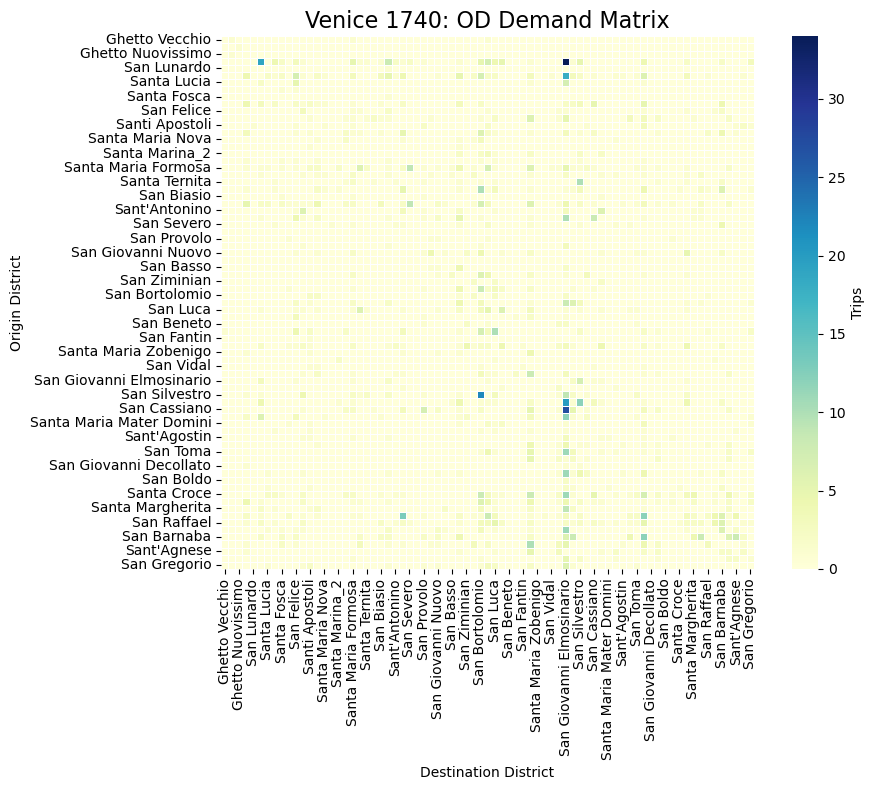

In [372]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_od_heatmap(od_matrix, title="OD Demand Heatmap"):
    """
    Plot a heatmap of the OD matrix.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(od_matrix, 
                cmap="YlGnBu", 
                annot=False,   # Set True to display numbers
                fmt=".0f", 
                linewidths=.5, 
                square=True, 
                cbar_kws={'label': 'Trips'})
    plt.title(title, fontsize=16)
    plt.xlabel("Destination District")
    plt.ylabel("Origin District")
    plt.tight_layout()
    plt.show()

# Usage:
plot_od_heatmap(od_matrix, title="Venice 1740: OD Demand Matrix")

In [373]:
TRAGHETTO_ROUTES = [
    ("San Mattio",  "Santa Sofia"),
    ("San Gregorio","San Moise"),
    ("San Polo",    "San Beneto"),
    ("San Stae",    "Santa Maria Maddalena"),
    ("San Samuel",  "San Trovaso"),
]

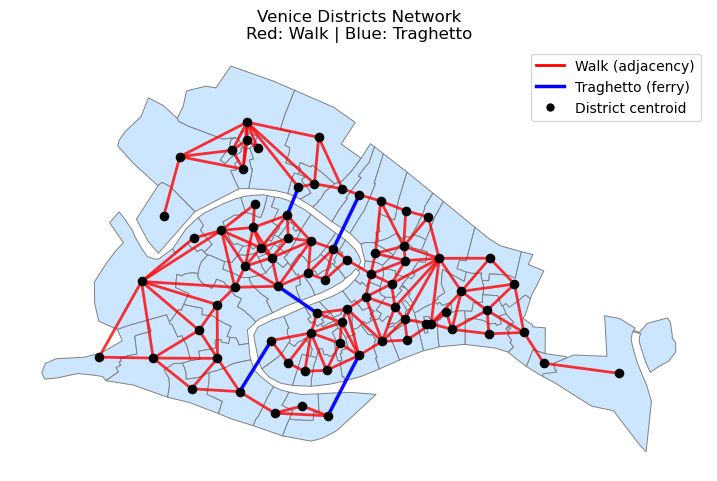

In [376]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_network_style(gdf, adj_matrix, traghetto_routes):
    """
    Visualize Venice district network.
    - Walk links (adj_matrix==1): red
    - Traghetto links (from list): blue
    - Districts: light blue
    - With legend
    """
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    gdf.plot(ax=ax, facecolor="#cce6ff", edgecolor="grey", lw=0.7)

    # Get centroids
    centroids = gdf.geometry.centroid
    xs = centroids.x.values
    ys = centroids.y.values
    names = list(gdf['NAME'])

    # Plot walk links (red)
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):
            if adj_matrix[i, j] == 1:
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color="red", lw=2, alpha=0.8, zorder=2)

    # Plot traghetto links (blue)
    for o, d in traghetto_routes:
        if o in names and d in names:
            i, j = names.index(o), names.index(d)
            ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color="blue", lw=2.5, alpha=0.95, zorder=3)
        else:
            print(f"Warning: {o} or {d} not found in gdf['NAME'].")

    # Draw nodes
    ax.scatter(xs, ys, s=35, c="k", zorder=4)

    ax.set_title('Venice Districts Network\nRed: Walk | Blue: Traghetto')
    ax.axis('off')

    # Add custom legend
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Walk (adjacency)'),
        Line2D([0], [0], color='blue', lw=2.5, label='Traghetto (ferry)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=7, label='District centroid')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True)

    plt.show()

visualize_network_style(district_gdf, adjacency_matrix, TRAGHETTO_ROUTES)

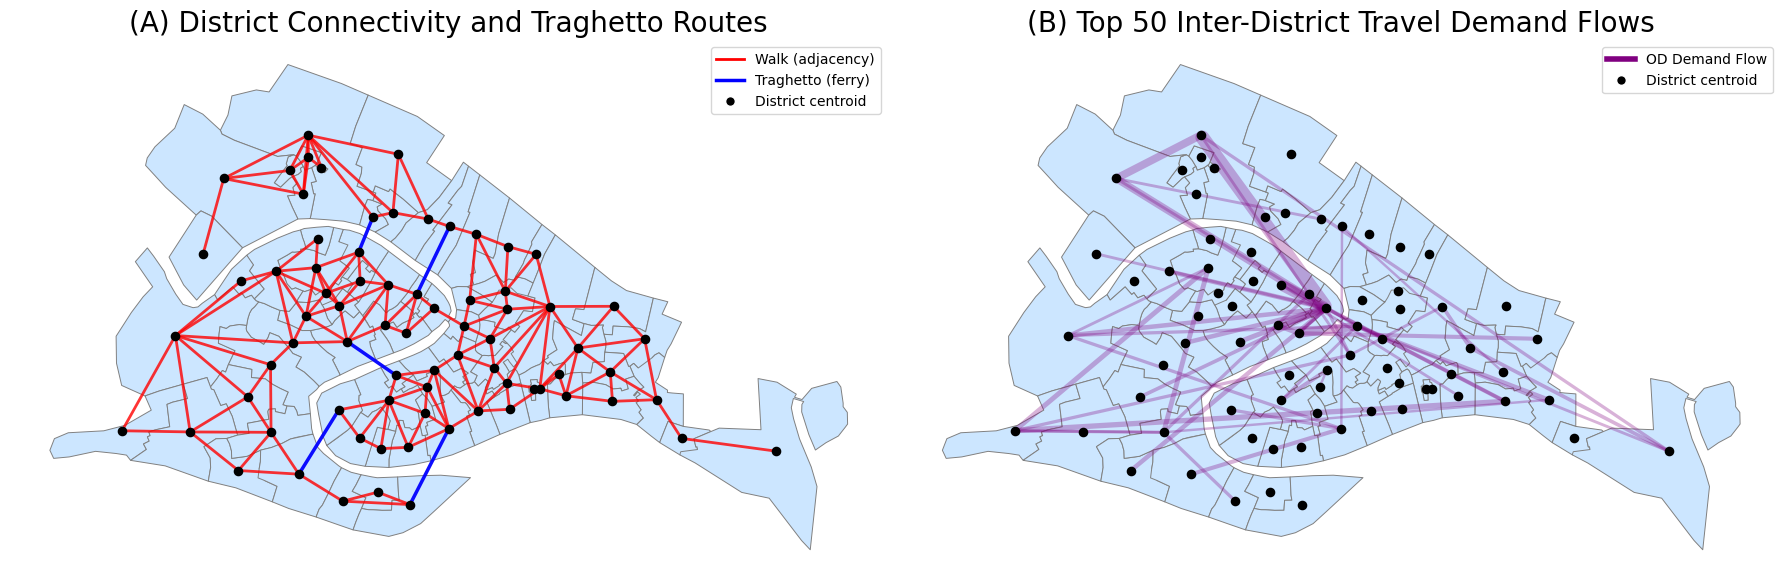

In [392]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
import numpy as np

def plot_network_on_ax(gdf, adj_matrix, traghetto_routes, ax):
    """
    Plot the Venice district network.
    - Walking links: red
    - Traghetto links: blue
    - District centroids: black dots
    """
    gdf.plot(ax=ax, facecolor="#cce6ff", edgecolor="grey", lw=0.7)
    centroids = gdf.geometry.centroid
    xs = centroids.x.values
    ys = centroids.y.values
    names = list(gdf['NAME'])

    # Plot walking links (red lines)
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):
            if adj_matrix[i, j] == 1:
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color="red", lw=2, alpha=0.8, zorder=2)

    # Plot traghetto (ferry) links (blue lines)
    for o, d in traghetto_routes:
        if o in names and d in names:
            i, j = names.index(o), names.index(d)
            ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color="blue", lw=2.5, alpha=0.95, zorder=3)

    # Plot district centroids as black dots
    ax.scatter(xs, ys, s=35, c="k", zorder=4)
    ax.set_title('(A) District Connectivity and Traghetto Routes', fontsize=20)
    ax.axis('off')

    # Custom legend for the network plot (left)
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Walk (adjacency)'),
        Line2D([0], [0], color='blue', lw=2.5, label='Traghetto (ferry)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=7, label='District centroid')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True)

def plot_od_arcs_on_ax(gdf, od_matrix, ax, N=50, color="purple"):
    """
    Plot the top-N OD demand flows as curves between district centroids.
    - OD arcs: purple, width proportional to demand
    - District centroids: black dots
    """
    centroids = gdf.set_index('NAME').geometry.centroid
    xy = centroids.apply(lambda p: (p.x, p.y))
    gdf.plot(ax=ax, facecolor="#cce6ff", edgecolor='gray', linewidth=0.7)

    # Get top N OD pairs by demand (excluding self-loops)
    od_pairs = od_matrix.stack().sort_values(ascending=False)
    od_pairs = od_pairs[od_pairs > 0].head(N)

    def plot_arc(ax, x0, y0, x1, y1, w, color, alpha=0.3, curviness=0):
        # Draw a curved arc between two points, width proportional to w
        arrow = FancyArrowPatch(
            (x0, y0), (x1, y1),
            connectionstyle=f"arc3,rad={curviness}",
            arrowstyle='-',
            linewidth= 10*w/od_pairs.max(),
            color=color, alpha=alpha, zorder=5)
        ax.add_patch(arrow)

    # Draw all selected OD arcs
    for (o, d), demand in od_pairs.items():
        if o == d:
            continue
        x0, y0 = xy[o]
        x1, y1 = xy[d]
        plot_arc(ax, x0, y0, x1, y1, w=demand, color=color, curviness=0)

    # Draw centroids on top
    ax.scatter([xy[o][0] for o in od_matrix.index], [xy[o][1] for o in od_matrix.index], s=35, c="k", zorder=6)
    ax.set_title(f"(B) Top {N} Inter-District Travel Demand Flows", fontsize=20)
    ax.axis('off')

    # Custom legend for the OD plot (right)
    legend_elements = [
        Line2D([0], [0], color=color, lw=4, label='OD Demand Flow'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=7, label='District centroid')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True)

# Combine as subplots: left = network, right = OD flows
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

plot_network_on_ax(district_gdf, adjacency_matrix, TRAGHETTO_ROUTES, ax1)
plot_od_arcs_on_ax(district_gdf, od_matrix, ax2, N=50, color="purple")

plt.tight_layout()
plt.show()

In [260]:
# Assuming:
# - district_gdf: GeoDataFrame with index or column 'district' and 'side_canal'
# - od_matrix: DataFrame with index and columns matching district names

# Map from district to side
side_dict = district_gdf.set_index('NAME')['side_canal'].to_dict()

cross_canal_pairs = []
cross_canal_total_demand = 0
for o in od_matrix.index:
    for d in od_matrix.columns:
        if side_dict[o] != side_dict[d]:
            cross_canal_pairs.append((o, d))
            cross_canal_total_demand += od_matrix.at[o, d]

print(f"Number of cross-canal OD pairs: {len(cross_canal_pairs)}")
print(f"Total cross-canal demand: {cross_canal_total_demand:.1f} trips/day")
print(f"Share of cross-canal demand: {100 * cross_canal_total_demand / od_matrix.values.sum():.2f}%")

Number of cross-canal OD pairs: 2430
Total cross-canal demand: 775.0 trips/day
Share of cross-canal demand: 39.18%


In [269]:
adjacency_df = pd.DataFrame(adjacency_matrix, index=district_names, columns=district_names)

In [ ]:
"""
Venice-1740 Multimodal Traffic Assignment  –  Frank–Wolfe version (fixed)
------------------------------------------------------------------------
• Walking links   – BPR delay   (α = 0.20, β = 1)
• Traghetto links – BPR delay   (α = 1.00, β = 2)  + optional queue term
• UE solved with classic Frank–Wolfe  + exact line-search
• SO solved with FW on marginal costs (uses derivative of the new BPR)
• Built-in plotting and traghetto-specific statistics
author : <your name>   |   last edit : 2025-06-08
"""

import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path
from scipy.optimize import minimize_scalar   # 1-D bounded line search
# ────────────────────────────────────────────────────────────────────────────
# 0 · GLOBAL SETTINGS
# ────────────────────────────────────────────────────────────────────────────
POP, TRIPS_PER_PERSON = 140_000, 1      # inhabitants · trips/day/head
T_ROW                 = 5.0               # min  – rowing time
FARE,  VOT            = 0.3, 0.1          # lire,  lire/min  (=> 0.3 ÷ 0.1 = 3 min)
USE_QUEUE_DELAY       = False              # add queue term when x > cap
QUEUE_FACTOR          = dict(walk=0.0, boat=2.5)    # extra min per cap-unit
PEAK_HOUR_FACTOR      = 10.0              # 1/10 of daily trips = design hour
MAX_ITER, EPS         = 100, 1e-2          # Frank–Wolfe settings
# ---------------------------------------------------------------------------
# parameter table – one row per MODE
# ---------------------------------------------------------------------------
PARAM = {
    1: dict(name='walk',  cap= 5000, alpha=0.15, beta=1, gamma=QUEUE_FACTOR['walk']),
    2: dict(name='boat',  cap=   500, alpha=0.30, beta=1, gamma=QUEUE_FACTOR['boat']),
}
# ---------------------------------------------------------------------------
TRAGHETTO_ROUTES = []
# ═══════════════════════════════════════════════════════════════════════════
# 1 · NETWORK BUILDER
# ═══════════════════════════════════════════════════════════════════════════
def build_network(cost_df: pd.DataFrame,   # free-flow walk times (min)
                  adj_df : pd.DataFrame):
    """Inject traghetto links and return all link-attribute matrices."""
    names  = list(cost_df.index)
    n      = len(names)

    # --- initialise as WALK -------------------------------------------------
    cost  = cost_df.copy()
    typ   = pd.DataFrame(1, index=names, columns=names) * 1        # 1 = walk
    cap   = pd.DataFrame(PARAM[1]['cap'],   index=names, columns=names)
    alpha = pd.DataFrame(PARAM[1]['alpha'], index=names, columns=names)
    beta  = pd.DataFrame(PARAM[1]['beta'],  index=names, columns=names)
    gamma = pd.DataFrame(PARAM[1]['gamma'], index=names, columns=names)

    # --- add traghetti ------------------------------------------------------
    t_boat = T_ROW + FARE / VOT           # generalised ferry cost (min)
    for o, d in TRAGHETTO_ROUTES:
        if o not in names or d not in names:
            print(f"⚠  {o} ↔ {d} not found in district list");  continue
        adj_df.at[o, d] = adj_df.at[d, o] = 1
        cost .at[o, d]  = cost .at[d, o]  = t_boat
        typ  .at[o, d]  = typ  .at[d, o]  = 2
        for df,key in zip([cap, alpha, beta, gamma], ['cap','alpha','beta','gamma']):
            df.at[o, d] = df.at[d, o] = PARAM[2][key]

    return cost, adj_df, typ.values, cap.values, alpha.values, beta.values, \
           gamma.values, names
# ═══════════════════════════════════════════════════════════════════════════
# 2 · COST FUNCTION
# ═══════════════════════════════════════════════════════════════════════════
def link_delay(t0, x, c, a, b, g):
    """Generalised BPR + optional queue penalty."""
    t = t0 * (1 + a * (x / c) ** b)
    if USE_QUEUE_DELAY and x > c:
        t += g * (x / c - 1) * t0
    return t
# ═══════════════════════════════════════════════════════════════════════════
# 3 · CORE ROUTINES  (AON, time-update, Frank–Wolfe)
# ═══════════════════════════════════════════════════════════════════════════
def aon(time_df, od_df):
    """All-or-nothing assignment."""
    cost = np.ascontiguousarray(time_df.replace(np.inf, 1e9).values)
    _, pred = shortest_path(cost, return_predecessors=True)
    n   = cost.shape[0]
    flw = np.zeros_like(cost)
    for o in range(n):
        for d in range(n):
            q = od_df.values[o, d]
            if q == 0: continue
            p, k = [d], d
            while k != o and k != -9999:
                k = pred[o, k];  p.append(k)
            p.reverse()
            for u,v in zip(p[:-1], p[1:]):
                flw[u,v] += q
    return flw

def update_times(t0_df, fl, cap, al, be, ga):
    """Return new travel-time DataFrame given flows."""
    t = t0_df.copy()
    n = fl.shape[0]
    for i in range(n):
        for j in range(n):
            if np.isfinite(t0_df.iat[i,j]):
                t.iat[i,j] = link_delay(t0_df.iat[i,j],
                                        fl[i,j], cap[i,j], al[i,j],
                                        be[i,j], ga[i,j])
    return t

def total_system_time(flow, time_df):
    m = flow > 0
    return np.sum(flow[m] * time_df.values[m])

def fw_user_equil(t0_df, od_df, cap, al, be, ga):
    """Wardrop UE with classic Frank–Wolfe and exact line search."""
    fl = aon(t0_df, od_df)
    for k in range(MAX_ITER):
        tim   = update_times(t0_df, fl, cap, al, be, ga)
        aux   = aon(tim, od_df)

        def obj(lam):
            f = (1-lam)*fl + lam*aux
            return total_system_time(f, update_times(t0_df, f, cap, al, be, ga))

        lam_star = minimize_scalar(obj, bounds=(0,1), method='bounded').x
        new_fl   = (1-lam_star)*fl + lam_star*aux
        gap      = np.abs(new_fl-fl).max() / (fl.max()+1e-6)
        print(f"  UE iter {k+1:2d}  λ*={lam_star:5.3f}  gap={gap:6.4f}")
        fl = new_fl
        if gap < EPS: break
    return fl, update_times(t0_df, fl, cap, al, be, ga)

def fw_system_opt(t0_df, od_df, cap, al, be, ga):
    """System-Optimum via FW on marginal costs."""
    fl = aon(t0_df, od_df)
    for k in range(MAX_ITER):
        marg = t0_df.copy()
        n = fl.shape[0]
        # Correct marginal cost for BPR function
        for i in range(n):
            for j in range(n):
                if not np.isfinite(t0_df.iat[i,j]):  continue
                t0  = t0_df.iat[i,j];  x = fl[i,j];  c = cap[i,j]
                a,b = al[i,j], be[i,j]
                # Marginal cost: t0 * (1 + a*(1+b)*(x/c)**b)
                marg.iat[i,j] = t0 * (1 + a * (1 + b) * (x / c) ** b)

        aux = aon(marg, od_df)

        def obj(lam):
            f = (1-lam)*fl + lam*aux
            return total_system_time(f, update_times(t0_df, f, cap, al, be, ga))

        lam_star = minimize_scalar(obj, bounds=(0,1), method='bounded').x
        new_fl   = (1-lam_star)*fl + lam_star*aux
        gap      = np.abs(new_fl-fl).max()/(fl.max()+1e-6)
        print(f"  SO iter {k+1:2d}  λ*={lam_star:5.3f}  gap={gap:6.4f}")
        fl = new_fl
        if gap < EPS: break
    return fl, update_times(t0_df, fl, cap, al, be, ga)
# ═══════════════════════════════════════════════════════════════════════════
# 4 · REPORTING + PLOTTING
# ═══════════════════════════════════════════════════════════════════════════
def print_traghetto(fl, typ, names, od_tot, tag=""):
    print(f"\n{tag} Traghetto flows")
    print("Route".ljust(35),"Daily trips","Peak-h p/h",sep=" | ")
    for o,d in TRAGHETTO_ROUTES:
        try:
            i,j = names.index(o), names.index(d)
            tot = fl[i,j] + fl[j,i]
            print(f"{o:<15}–{d:<15} | {tot:11.1f} | {tot/PEAK_HOUR_FACTOR:10.1f}")
        except ValueError: pass
    print(f"Modal share (ferry): {fl[typ==2].sum()/od_tot*100:.1f}%")

def plot_links_subplots(ue_flow, so_flow, typ, names, gdf):
    """Plot UE and SO flows as side-by-side subplots, using the traffic assignment style."""
    cen = gdf.geometry.centroid
    xs, ys = cen.x.values, cen.y.values

    # Maximum values for scaling linewidths
    vmax_w = max(ue_flow[typ==1].max() if np.any(typ==1) else 1,
                 so_flow[typ==1].max() if np.any(typ==1) else 1)
    vmax_b = max(ue_flow[typ==2].max() if np.any(typ==2) else 1,
                 so_flow[typ==2].max() if np.any(typ==2) else 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
    titles = ["(A) User Equilibrium (UE) Flows", "(B) System Optimum (SO) Flows"]
    flows = [ue_flow, so_flow]

    for ax, flow, title in zip(axes, flows, titles):
        gdf.plot(ax=ax, facecolor="#cce6ff", edgecolor="grey", lw=0.4)
        ax.scatter(xs, ys, s=30, c="k", zorder=3)
        for i in range(len(names)):
            for j in range(len(names)):
                f = flow[i, j]
                if f == 0:
                    continue
                # Navy: traghetto (type==2), Red: walk (type==1)
                lw = 0.3 + 4 * f / (vmax_b if typ[i,j]==2 else vmax_w)
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]],
                        color="navy" if typ[i,j]==2 else "red",
                        lw=lw, alpha=0.8)
        ax.set_title(title, fontsize=14)
        ax.axis("off")

    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Walk'),
        Line2D([0], [0], color='navy', lw=2, label='Traghetto (ferry)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='District centroid')
    ]
    axes[0].legend(handles=legend_elements, loc='lower left', frameon=True, fontsize=12)

    plt.show()
# ═══════════════════════════════════════════════════════════════════════════
# 5 · WRAPPER
# ═══════════════════════════════════════════════════════════════════════════
def run_assignment(cost_df, od_df, adj_df, gdf):
    scale   = POP * TRIPS_PER_PERSON / od_df.values.sum()
    od_day  = od_df * scale

    t0, adj, typ, cap, al, be, ga, names = build_network(
        cost_df.copy(), adj_df.copy())

    print("\n===== USER EQUILIBRIUM =====")
    ue_f, ue_t = fw_user_equil(t0, od_day, cap, al, be, ga)

    print("\n===== SYSTEM OPTIMUM =====")
    so_f, so_t = fw_system_opt(t0, od_day, cap, al, be, ga)

    def avg_tt(f,t): return total_system_time(f,t)/od_day.values.sum()
    print(f"\n[UE] avg trip time = {avg_tt(ue_f,ue_t):.2f} min")
    print(f"[SO] avg trip time = {avg_tt(so_f,so_t):.2f} min")
    print(f"Price of Anarchy   = {total_system_time(ue_f,ue_t) / total_system_time(so_f,so_t):.3f}")

    print_traghetto(ue_f, typ, names, od_day.values.sum(), tag="[UE]")
    print_traghetto(so_f, typ, names, od_day.values.sum(), tag="[SO]")

    plot_links_subplots(ue_f, so_f, typ, names, gdf)
# ────────────────────────────────────────────────────────────────────────────
# Example call (in your notebook / script):
# run_assignment(cost_matrix, od_matrix, adjacency_matrix, district_gdf)


===== USER EQUILIBRIUM =====
  UE iter  1  λ*=0.427  gap=0.4267
  UE iter  2  λ*=0.238  gap=0.1701
  UE iter  3  λ*=0.112  gap=0.0400
  UE iter  4  λ*=0.073  gap=0.0498
  UE iter  5  λ*=0.000  gap=0.0000

===== SYSTEM OPTIMUM =====
  SO iter  1  λ*=0.357  gap=0.3565
  SO iter  2  λ*=0.232  gap=0.1411
  SO iter  3  λ*=0.138  gap=0.1304
  SO iter  4  λ*=0.092  gap=0.0717
  SO iter  5  λ*=0.106  gap=0.0667
  SO iter  6  λ*=0.058  gap=0.0448
  SO iter  7  λ*=0.085  gap=0.0325
  SO iter  8  λ*=0.070  gap=0.0336
  SO iter  9  λ*=0.051  gap=0.0445
  SO iter 10  λ*=0.069  gap=0.0262
  SO iter 11  λ*=0.045  gap=0.0234
  SO iter 12  λ*=0.050  gap=0.0296
  SO iter 13  λ*=0.044  gap=0.0230
  SO iter 14  λ*=0.050  gap=0.0179
  SO iter 15  λ*=0.040  gap=0.0255
  SO iter 16  λ*=0.038  gap=0.0170
  SO iter 17  λ*=0.037  gap=0.0221
  SO iter 18  λ*=0.024  gap=0.0186
  SO iter 19  λ*=0.041  gap=0.0153
  SO iter 20  λ*=0.032  gap=0.0144
  SO iter 21  λ*=0.024  gap=0.0141
  SO iter 22  λ*=0.032  gap=0.01

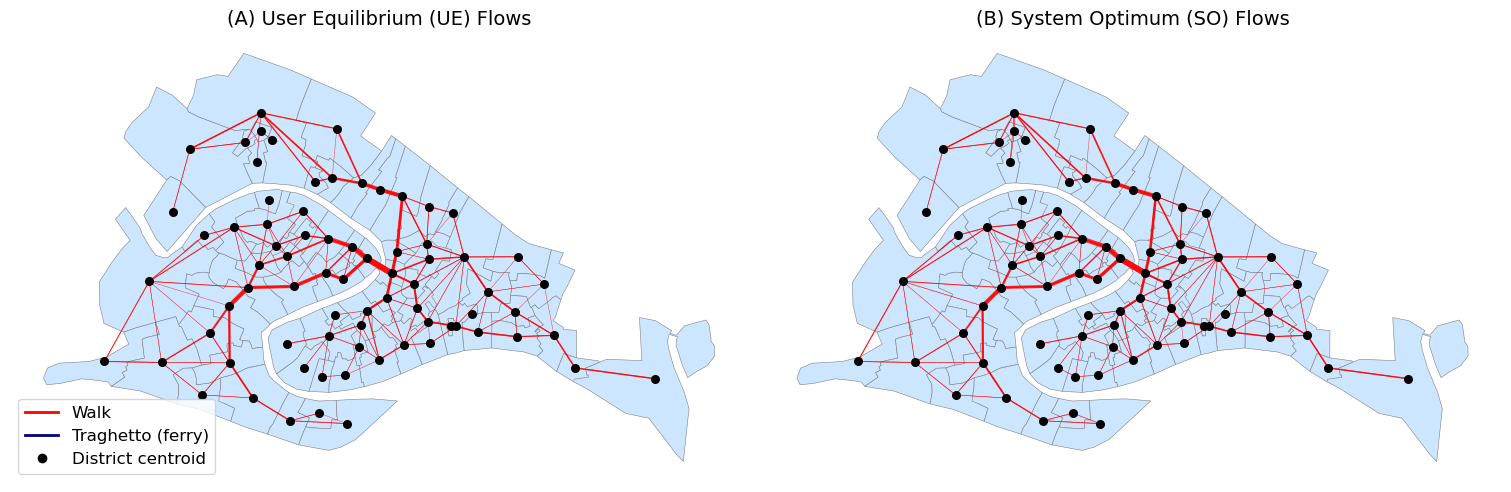

In [414]:
run_assignment(cost_matrix, od_matrix, adjacency_df, district_gdf)

In [415]:
"""
Venice-1740 Multimodal Traffic Assignment  –  Frank–Wolfe version (fixed)
------------------------------------------------------------------------
• Walking links   – BPR delay   (α = 0.20, β = 1)
• Traghetto links – BPR delay   (α = 1.00, β = 2)  + optional queue term
• UE solved with classic Frank–Wolfe  + exact line-search
• SO solved with FW on marginal costs (uses derivative of the new BPR)
• Built-in plotting and traghetto-specific statistics
author : <your name>   |   last edit : 2025-06-08
"""

import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path
from scipy.optimize import minimize_scalar   # 1-D bounded line search
# ────────────────────────────────────────────────────────────────────────────
# 0 · GLOBAL SETTINGS
# ────────────────────────────────────────────────────────────────────────────
POP, TRIPS_PER_PERSON = 140_000, 1      # inhabitants · trips/day/head
T_ROW                 = 5.0               # min  – rowing time
FARE,  VOT            = 0.3, 0.1          # lire,  lire/min  (=> 0.3 ÷ 0.1 = 3 min)
USE_QUEUE_DELAY       = False              # add queue term when x > cap
QUEUE_FACTOR          = dict(walk=0.0, boat=2)    # extra min per cap-unit
PEAK_HOUR_FACTOR      = 10.0              # 1/10 of daily trips = design hour
MAX_ITER, EPS         = 100, 1e-2          # Frank–Wolfe settings
# ---------------------------------------------------------------------------
# parameter table – one row per MODE
# ---------------------------------------------------------------------------
PARAM = {
    1: dict(name='walk',  cap= 5000, alpha=0.15, beta=1, gamma=QUEUE_FACTOR['walk']),
    2: dict(name='boat',  cap=   500, alpha=0.30, beta=1, gamma=QUEUE_FACTOR['boat']),
}
# ---------------------------------------------------------------------------
TRAGHETTO_ROUTES = [
    ("San Mattio",  "Santa Sofia"),
    ("San Gregorio","San Moise"),
    ("San Polo",    "San Beneto"),
    ("San Stae",    "Santa Maria Maddalena"),
    ("San Samuel",  "San Trovaso"),
]
# ═══════════════════════════════════════════════════════════════════════════
# 1 · NETWORK BUILDER
# ═══════════════════════════════════════════════════════════════════════════
def build_network(cost_df: pd.DataFrame,   # free-flow walk times (min)
                  adj_df : pd.DataFrame):
    """Inject traghetto links and return all link-attribute matrices."""
    names  = list(cost_df.index)
    n      = len(names)

    # --- initialise as WALK -------------------------------------------------
    cost  = cost_df.copy()
    typ   = pd.DataFrame(1, index=names, columns=names) * 1        # 1 = walk
    cap   = pd.DataFrame(PARAM[1]['cap'],   index=names, columns=names)
    alpha = pd.DataFrame(PARAM[1]['alpha'], index=names, columns=names)
    beta  = pd.DataFrame(PARAM[1]['beta'],  index=names, columns=names)
    gamma = pd.DataFrame(PARAM[1]['gamma'], index=names, columns=names)

    # --- add traghetti ------------------------------------------------------
    t_boat = T_ROW + FARE / VOT           # generalised ferry cost (min)
    for o, d in TRAGHETTO_ROUTES:
        if o not in names or d not in names:
            print(f"⚠  {o} ↔ {d} not found in district list");  continue
        adj_df.at[o, d] = adj_df.at[d, o] = 1
        cost .at[o, d]  = cost .at[d, o]  = t_boat
        typ  .at[o, d]  = typ  .at[d, o]  = 2
        for df,key in zip([cap, alpha, beta, gamma], ['cap','alpha','beta','gamma']):
            df.at[o, d] = df.at[d, o] = PARAM[2][key]

    return cost, adj_df, typ.values, cap.values, alpha.values, beta.values, \
           gamma.values, names
# ═══════════════════════════════════════════════════════════════════════════
# 2 · COST FUNCTION
# ═══════════════════════════════════════════════════════════════════════════
def link_delay(t0, x, c, a, b, g):
    """Generalised BPR + optional queue penalty."""
    t = t0 * (1 + a * (x / c) ** b)
    if USE_QUEUE_DELAY and x > c:
        t += g * (x / c - 1) * t0
    return t
# ═══════════════════════════════════════════════════════════════════════════
# 3 · CORE ROUTINES  (AON, time-update, Frank–Wolfe)
# ═══════════════════════════════════════════════════════════════════════════
def aon(time_df, od_df):
    """All-or-nothing assignment."""
    cost = np.ascontiguousarray(time_df.replace(np.inf, 1e9).values)
    _, pred = shortest_path(cost, return_predecessors=True)
    n   = cost.shape[0]
    flw = np.zeros_like(cost)
    for o in range(n):
        for d in range(n):
            q = od_df.values[o, d]
            if q == 0: continue
            p, k = [d], d
            while k != o and k != -9999:
                k = pred[o, k];  p.append(k)
            p.reverse()
            for u,v in zip(p[:-1], p[1:]):
                flw[u,v] += q
    return flw

def update_times(t0_df, fl, cap, al, be, ga):
    """Return new travel-time DataFrame given flows."""
    t = t0_df.copy()
    n = fl.shape[0]
    for i in range(n):
        for j in range(n):
            if np.isfinite(t0_df.iat[i,j]):
                t.iat[i,j] = link_delay(t0_df.iat[i,j],
                                        fl[i,j], cap[i,j], al[i,j],
                                        be[i,j], ga[i,j])
    return t

def total_system_time(flow, time_df):
    m = flow > 0
    return np.sum(flow[m] * time_df.values[m])

def fw_user_equil(t0_df, od_df, cap, al, be, ga):
    """Wardrop UE with classic Frank–Wolfe and exact line search."""
    fl = aon(t0_df, od_df)
    for k in range(MAX_ITER):
        tim   = update_times(t0_df, fl, cap, al, be, ga)
        aux   = aon(tim, od_df)

        def obj(lam):
            f = (1-lam)*fl + lam*aux
            return total_system_time(f, update_times(t0_df, f, cap, al, be, ga))

        lam_star = minimize_scalar(obj, bounds=(0,1), method='bounded').x
        new_fl   = (1-lam_star)*fl + lam_star*aux
        gap      = np.abs(new_fl-fl).max() / (fl.max()+1e-6)
        print(f"  UE iter {k+1:2d}  λ*={lam_star:5.3f}  gap={gap:6.4f}")
        fl = new_fl
        if gap < EPS: break
    return fl, update_times(t0_df, fl, cap, al, be, ga)

def fw_system_opt(t0_df, od_df, cap, al, be, ga):
    """System-Optimum via FW on marginal costs."""
    fl = aon(t0_df, od_df)
    for k in range(MAX_ITER):
        marg = t0_df.copy()
        n = fl.shape[0]
        # Correct marginal cost for BPR function
        for i in range(n):
            for j in range(n):
                if not np.isfinite(t0_df.iat[i,j]):  continue
                t0  = t0_df.iat[i,j];  x = fl[i,j];  c = cap[i,j]
                a,b = al[i,j], be[i,j]
                # Marginal cost: t0 * (1 + a*(1+b)*(x/c)**b)
                marg.iat[i,j] = t0 * (1 + a * (1 + b) * (x / c) ** b)

        aux = aon(marg, od_df)

        def obj(lam):
            f = (1-lam)*fl + lam*aux
            return total_system_time(f, update_times(t0_df, f, cap, al, be, ga))

        lam_star = minimize_scalar(obj, bounds=(0,1), method='bounded').x
        new_fl   = (1-lam_star)*fl + lam_star*aux
        gap      = np.abs(new_fl-fl).max()/(fl.max()+1e-6)
        print(f"  SO iter {k+1:2d}  λ*={lam_star:5.3f}  gap={gap:6.4f}")
        fl = new_fl
        if gap < EPS: break
    return fl, update_times(t0_df, fl, cap, al, be, ga)
# ═══════════════════════════════════════════════════════════════════════════
# 4 · REPORTING + PLOTTING
# ═══════════════════════════════════════════════════════════════════════════
def print_traghetto(fl, typ, names, od_tot, tag=""):
    print(f"\n{tag} Traghetto flows")
    print("Route".ljust(35),"Daily trips","Peak-h p/h",sep=" | ")
    for o,d in TRAGHETTO_ROUTES:
        try:
            i,j = names.index(o), names.index(d)
            tot = fl[i,j] + fl[j,i]
            print(f"{o:<15}–{d:<15} | {tot:11.1f} | {tot/PEAK_HOUR_FACTOR:10.1f}")
        except ValueError: pass
    print(f"Modal share (ferry): {fl[typ==2].sum()/od_tot*100:.1f}%")

def plot_links_subplots(ue_flow, so_flow, typ, names, gdf):
    """Plot UE and SO flows as side-by-side subplots, using the traffic assignment style."""
    cen = gdf.geometry.centroid
    xs, ys = cen.x.values, cen.y.values

    # Maximum values for scaling linewidths
    vmax_w = max(ue_flow[typ==1].max() if np.any(typ==1) else 1,
                 so_flow[typ==1].max() if np.any(typ==1) else 1)
    vmax_b = max(ue_flow[typ==2].max() if np.any(typ==2) else 1,
                 so_flow[typ==2].max() if np.any(typ==2) else 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
    titles = ["(A) User Equilibrium (UE) Flows", "(B) System Optimum (SO) Flows"]
    flows = [ue_flow, so_flow]

    for ax, flow, title in zip(axes, flows, titles):
        gdf.plot(ax=ax, facecolor="#cce6ff", edgecolor="grey", lw=0.4)
        ax.scatter(xs, ys, s=30, c="k", zorder=3)
        for i in range(len(names)):
            for j in range(len(names)):
                f = flow[i, j]
                if f == 0:
                    continue
                # Navy: traghetto (type==2), Red: walk (type==1)
                lw = 0.3 + 4 * f / (vmax_b if typ[i,j]==2 else vmax_w)
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]],
                        color="navy" if typ[i,j]==2 else "red",
                        lw=lw, alpha=0.8)
        ax.set_title(title, fontsize=14)
        ax.axis("off")

    # Custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, label='Walk'),
        Line2D([0], [0], color='navy', lw=2, label='Traghetto (ferry)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, label='District centroid')
    ]
    axes[0].legend(handles=legend_elements, loc='lower left', frameon=True, fontsize=12)

    plt.show()
# ═══════════════════════════════════════════════════════════════════════════
# 5 · WRAPPER
# ═══════════════════════════════════════════════════════════════════════════
def run_assignment(cost_df, od_df, adj_df, gdf):
    scale   = POP * TRIPS_PER_PERSON / od_df.values.sum()
    od_day  = od_df * scale

    t0, adj, typ, cap, al, be, ga, names = build_network(
        cost_df.copy(), adj_df.copy())

    print("\n===== USER EQUILIBRIUM =====")
    ue_f, ue_t = fw_user_equil(t0, od_day, cap, al, be, ga)

    print("\n===== SYSTEM OPTIMUM =====")
    so_f, so_t = fw_system_opt(t0, od_day, cap, al, be, ga)

    def avg_tt(f,t): return total_system_time(f,t)/od_day.values.sum()
    print(f"\n[UE] avg trip time = {avg_tt(ue_f,ue_t):.2f} min")
    print(f"[SO] avg trip time = {avg_tt(so_f,so_t):.2f} min")
    print(f"Price of Anarchy   = {total_system_time(ue_f,ue_t) / total_system_time(so_f,so_t):.3f}")

    print_traghetto(ue_f, typ, names, od_day.values.sum(), tag="[UE]")
    print_traghetto(so_f, typ, names, od_day.values.sum(), tag="[SO]")

    plot_links_subplots(ue_f, so_f, typ, names, gdf)
# ────────────────────────────────────────────────────────────────────────────
# Example call (in your notebook / script):
# run_assignment(cost_matrix, od_matrix, adjacency_matrix, district_gdf)


===== USER EQUILIBRIUM =====
  UE iter  1  λ*=0.529  gap=0.6380
  UE iter  2  λ*=0.376  gap=0.2532
  UE iter  3  λ*=0.279  gap=0.1592
  UE iter  4  λ*=0.135  gap=0.0787
  UE iter  5  λ*=0.122  gap=0.0781
  UE iter  6  λ*=0.071  gap=0.0370
  UE iter  7  λ*=0.000  gap=0.0000

===== SYSTEM OPTIMUM =====
  SO iter  1  λ*=0.448  gap=0.6735
  SO iter  2  λ*=0.365  gap=0.2414
  SO iter  3  λ*=0.232  gap=0.1850
  SO iter  4  λ*=0.178  gap=0.1208
  SO iter  5  λ*=0.230  gap=0.1407
  SO iter  6  λ*=0.123  gap=0.0840
  SO iter  7  λ*=0.135  gap=0.0753
  SO iter  8  λ*=0.091  gap=0.0700
  SO iter  9  λ*=0.080  gap=0.0704
  SO iter 10  λ*=0.121  gap=0.0482
  SO iter 11  λ*=0.067  gap=0.0309
  SO iter 12  λ*=0.070  gap=0.0380
  SO iter 13  λ*=0.069  gap=0.0325
  SO iter 14  λ*=0.060  gap=0.0321
  SO iter 15  λ*=0.079  gap=0.0511
  SO iter 16  λ*=0.048  gap=0.0258
  SO iter 17  λ*=0.054  gap=0.0301
  SO iter 18  λ*=0.053  gap=0.0268
  SO iter 19  λ*=0.050  gap=0.0267
  SO iter 20  λ*=0.046  gap=0.02

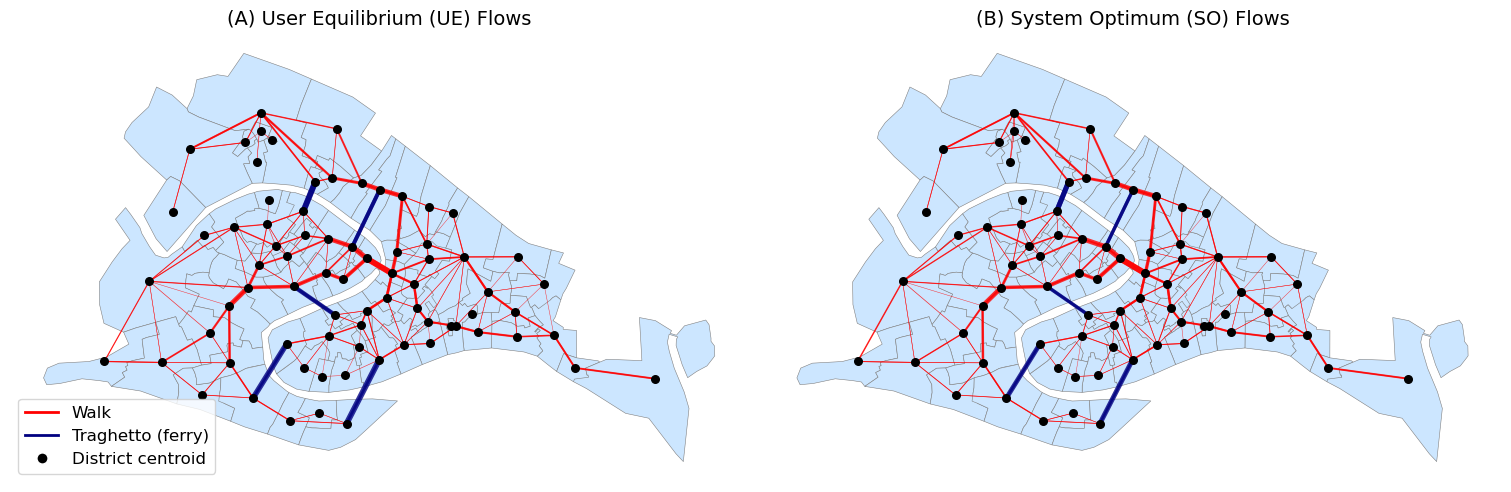

In [416]:
run_assignment(cost_matrix, od_matrix, adjacency_df, district_gdf)

In [456]:
import numpy as np
import pandas as pd
from scipy.sparse.csgraph import shortest_path

def build_network(cost_df, adj_df, traghetto_routes, 
                  walk_cap=5000, walk_alpha=0.15, walk_beta=1,
                  boat_cap=500, boat_alpha=0.3, boat_beta=1,
                  t_row=5.0, fare=0.3, vot=0.1):
    """Build all attribute matrices for a scenario (pure function)"""
    names = list(cost_df.index)
    n = len(names)
    # WALK attributes
    cost  = cost_df.copy()
    typ   = pd.DataFrame(1, index=names, columns=names)
    cap   = pd.DataFrame(walk_cap,   index=names, columns=names)
    alpha = pd.DataFrame(walk_alpha, index=names, columns=names)
    beta  = pd.DataFrame(walk_beta,  index=names, columns=names)

    # Add traghetti
    t_boat = t_row + fare / vot
    for o, d in traghetto_routes:
        if o not in names or d not in names:
            print(f"[Warning] {o} ↔ {d} not found.")
            continue
        cost .at[o, d]  = cost .at[d, o]  = t_boat
        typ  .at[o, d]  = typ  .at[d, o]  = 2
        cap  .at[o, d]  = cap  .at[d, o]  = boat_cap
        alpha.at[o, d]  = alpha.at[d, o]  = boat_alpha
        beta .at[o, d]  = beta .at[d, o]  = boat_beta

    return cost, typ.values, cap.values, alpha.values, beta.values, names

def link_delay(t0, x, c, a, b):
    return t0 * (1 + a * (x / c) ** b)

def aon(time_df, od_df):
    cost = np.ascontiguousarray(time_df.replace(np.inf, 1e9).values)
    _, pred = shortest_path(cost, return_predecessors=True)
    n = cost.shape[0]
    flw = np.zeros_like(cost)
    for o in range(n):
        for d in range(n):
            q = od_df.values[o, d]
            if q == 0: continue
            p, k = [d], d
            while k != o and k != -9999:
                k = pred[o, k]
                p.append(k)
            p.reverse()
            for u, v in zip(p[:-1], p[1:]):
                flw[u, v] += q
    return flw

def update_times(t0_df, fl, cap, al, be):
    t = t0_df.copy()
    n = fl.shape[0]
    for i in range(n):
        for j in range(n):
            if np.isfinite(t0_df.iat[i, j]):
                t.iat[i, j] = link_delay(t0_df.iat[i, j], fl[i, j], cap[i, j], al[i, j], be[i, j])
    return t

def total_system_time(flow, time_df):
    m = flow > 0
    return np.sum(flow[m] * time_df.values[m])

def frank_wolfe_assignment(t0_df, od_df, cap, al, be, typ, names, max_iter=100, eps=1e-2, SO=False):
    # If SO=True, use marginal cost
    fl = aon(t0_df, od_df)
    for k in range(max_iter):
        if not SO:
            tim = update_times(t0_df, fl, cap, al, be)
        else:
            marg = t0_df.copy()
            n = fl.shape[0]
            for i in range(n):
                for j in range(n):
                    if not np.isfinite(t0_df.iat[i, j]): continue
                    t0 = t0_df.iat[i, j]
                    x = fl[i, j]
                    c = cap[i, j]
                    a = al[i, j]
                    b = be[i, j]
                    marg.iat[i, j] = t0 * (1 + a * (1 + b) * (x / c) ** b)
            tim = marg
        aux = aon(tim, od_df)

        def obj(lam):
            f = (1 - lam) * fl + lam * aux
            return total_system_time(f, update_times(t0_df, f, cap, al, be))

        from scipy.optimize import minimize_scalar
        lam_star = minimize_scalar(obj, bounds=(0, 1), method='bounded').x
        new_fl = (1 - lam_star) * fl + lam_star * aux
        gap = np.abs(new_fl - fl).max() / (fl.max() + 1e-6)
        fl = new_fl
        if gap < eps: break
    tmat = update_times(t0_df, fl, cap, al, be)
    return fl, tmat

def assignment_scenario(cost_df, od_df, adj_df, traghetto_routes,
                        walk_cap=5000, walk_alpha=0.15, walk_beta=1,
                        boat_cap=500, boat_alpha=0.3, boat_beta=1,
                        t_row=5.0, fare=0.3, vot=0.1,
                        max_iter=100, eps=1e-2):
    """Full single-scenario run. Returns all key metrics for batch experiments."""
    # Build network
    t0, typ, cap, al, be, names = build_network(
        cost_df, adj_df, traghetto_routes,
        walk_cap, walk_alpha, walk_beta,
        boat_cap, boat_alpha, boat_beta,
        t_row, fare, vot
    )
    od_total = od_df.values.sum()
    # UE
    ue_f, ue_t = frank_wolfe_assignment(t0, od_df, cap, al, be, typ, names, max_iter, eps, SO=False)
    # SO
    so_f, so_t = frank_wolfe_assignment(t0, od_df, cap, al, be, typ, names, max_iter, eps, SO=True)
    # Metrics
    share_ue = ue_f[typ==2].sum() / od_total * 100
    share_so = so_f[typ==2].sum() / od_total * 100
    avg_tt_ue = total_system_time(ue_f, ue_t) / od_total
    avg_tt_so = total_system_time(so_f, so_t) / od_total
    poa = total_system_time(ue_f, ue_t) / total_system_time(so_f, so_t)
    traghetto_demand_ue = ue_f[typ==2].sum()   
    traghetto_demand_so = so_f[typ==2].sum()   
    # Output
    return {
    "share_ue": share_ue,
    "share_so": share_so,
    "avg_tt_ue": avg_tt_ue,
    "avg_tt_so": avg_tt_so,
    "poa": poa,
    "ue_demand": traghetto_demand_ue,
    "so_demand": traghetto_demand_so,
    "ue_f": ue_f,
    "so_f": so_f,
    "typ": typ,
    "names": names
    }

In [457]:
def run_batch(
    fare_list, cap_list, cost_df, od_df, adj_df, traghetto_routes,
    walk_cap=5000, walk_alpha=0.15, walk_beta=1,
    boat_alpha=0.3, boat_beta=1,
    t_row=5.0, vot=0.1,
    max_iter=100, eps=1e-2
):
    """Run all combinations of (fare, capacity) for traghetto, return DataFrame."""
    records = []
    for fare in fare_list:
        for boat_cap in cap_list:
            result = assignment_scenario(
                cost_df, od_df, adj_df, traghetto_routes,
                walk_cap, walk_alpha, walk_beta,
                boat_cap, boat_alpha, boat_beta,
                t_row, fare, vot, max_iter, eps
            )
            rec = {
                "fare": fare,
                "capacity": boat_cap,
                "share_ue": result["share_ue"],
                "share_so": result["share_so"],
                "avg_tt_ue": result["avg_tt_ue"],
                "avg_tt_so": result["avg_tt_so"],
                "poa": result["poa"],
                "ue_demand": result["ue_demand"],
                "so_demand": result["so_demand"],
            }
            records.append(rec)
    return pd.DataFrame(records)

In [458]:
# ---- Put your real data here ----
# cost_matrix, od_matrix, adjacency_matrix, district_gdf

TRAGHETTO_ROUTES = [
    ("San Mattio",  "Santa Sofia"),
    ("San Gregorio","San Moise"),
    ("San Polo",    "San Beneto"),
    ("San Stae",    "Santa Maria Maddalena"),
    ("San Samuel",  "San Trovaso"),
]

fare_grid = np.linspace(0.1, 4.0, 8)         # e.g. 0.1 ~ 2.0 lire
cap_grid  = [100, 300, 500, 700, 900]       # pax per hour

results = run_batch(
    fare_grid, cap_grid,
    cost_matrix, od_matrix, adjacency_matrix, TRAGHETTO_ROUTES
)
print(results.head())

   fare  capacity   share_ue   share_so  avg_tt_ue  avg_tt_so       poa  \
0   0.1       100  25.680597  22.724114  16.673297  16.652740  1.001234   
1   0.1       300  26.926375  26.436014  16.489769  16.488921  1.000051   
2   0.1       500  26.974665  26.935308  16.449399  16.448871  1.000032   
3   0.1       700  26.974665  26.949890  16.431094  16.431033  1.000004   
4   0.1       900  26.974665  26.974665  16.420857  16.420860  1.000000   

    ue_demand   so_demand  
0  516.950426  457.436408  
1  542.027930  532.156963  
2  543.000000  542.207755  
3  543.000000  542.501290  
4  543.000000  543.000000  


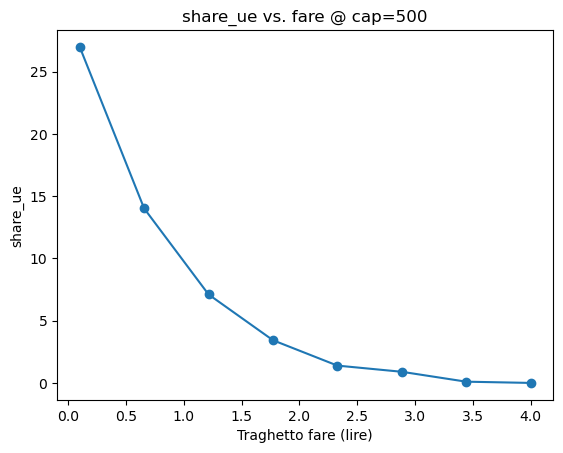

In [459]:
import matplotlib.pyplot as plt

def plot_heatmap(df, value='share_ue'):
    pivot = df.pivot(index='capacity', columns='fare', values=value)
    plt.figure(figsize=(8,5))
    plt.imshow(pivot, aspect='auto', origin='lower', cmap='plasma')
    plt.colorbar(label=value)
    plt.xticks(np.arange(len(pivot.columns)), [f'{v:.2f}' for v in pivot.columns])
    plt.yticks(np.arange(len(pivot.index)), pivot.index)
    plt.xlabel("Traghetto fare (lire)")
    plt.ylabel("Traghetto capacity (pax/h)")
    plt.title(f"Heatmap of {value}")
    plt.show()

def plot_response(df, fare=None, capacity=None, value='share_ue'):
    if (fare is None) == (capacity is None):
        raise ValueError("Specify exactly one of fare or capacity")
    if fare is not None:
        d = df[df['fare'] == fare].sort_values('capacity')
        plt.plot(d['capacity'], d[value], '-o')
        plt.xlabel("Traghetto capacity (pax/h)")
        plt.title(f"{value} vs. capacity @ fare={fare}")
    else:
        d = df[df['capacity'] == capacity].sort_values('fare')
        plt.plot(d['fare'], d[value], '-o')
        plt.xlabel("Traghetto fare (lire)")
        plt.title(f"{value} vs. fare @ cap={capacity}")
    plt.ylabel(value)
    plt.show()

# Example plot
#plot_heatmap(results, value="share_ue")
#plot_response(results, fare=0.3, value="share_ue")
plot_response(results, capacity=500, value="share_ue")

In [460]:
results["revenue_ue"] = results["fare"] * results["ue_demand"]
results["revenue_so"] = results["fare"] * results["so_demand"]

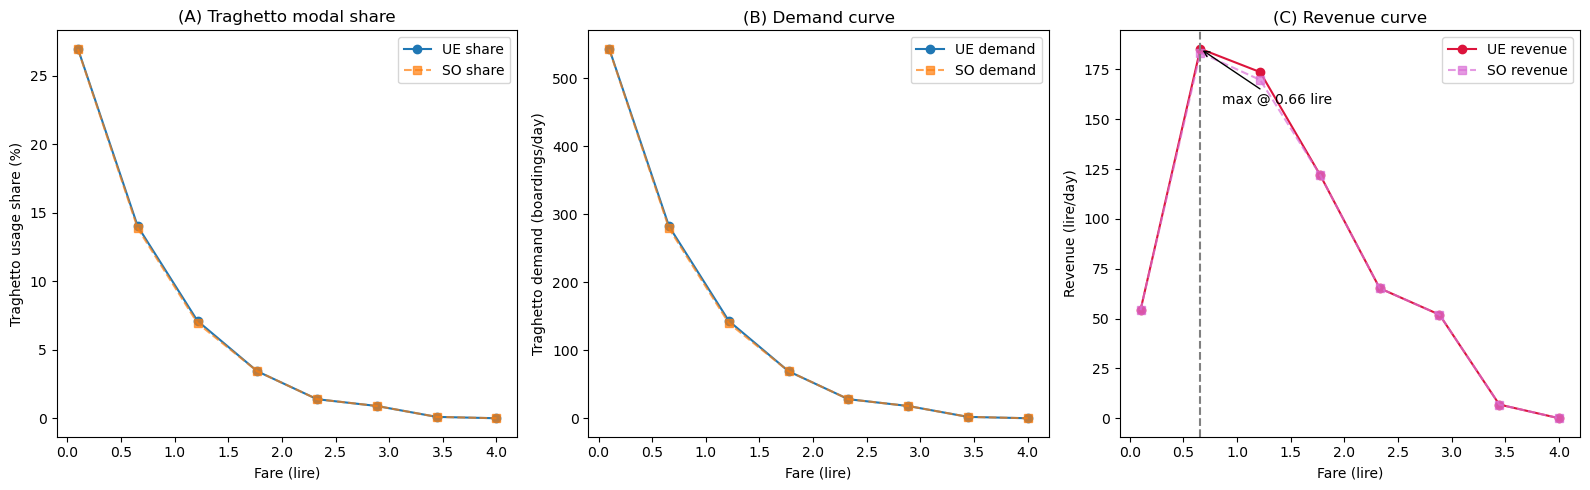

In [469]:
import matplotlib.pyplot as plt

def plot_demand_share_and_revenue_curve(df, capacity=500):
    # Filter by capacity
    d = df[df["capacity"] == capacity].sort_values("fare")
    plt.figure(figsize=(16, 5))

    # 1. Share subplot (left)
    plt.subplot(1, 3, 1)
    plt.plot(d["fare"], d["share_ue"], 'o-', label='UE share')
    plt.plot(d["fare"], d["share_so"], 's--', label='SO share', alpha=0.7)
    plt.xlabel("Fare (lire)")
    plt.ylabel("Traghetto usage share (%)")
    plt.title("(A) Traghetto modal share")
    plt.legend()

    # 2. Demand subplot (center)
    plt.subplot(1, 3, 2)
    plt.plot(d["fare"], d["ue_demand"], 'o-', label='UE demand')
    plt.plot(d["fare"], d["so_demand"], 's--', label='SO demand', alpha=0.7)
    plt.xlabel("Fare (lire)")
    plt.ylabel("Traghetto demand (boardings/day)")
    plt.title("(B) Demand curve")
    plt.legend()

    # 3. Revenue subplot (right)
    plt.subplot(1, 3, 3)
    plt.plot(d["fare"], d["revenue_ue"], 'o-', color='crimson', label='UE revenue')
    plt.plot(d["fare"], d["revenue_so"], 's--', color='orchid', label='SO revenue', alpha=0.7)
    max_ue = d.loc[d["revenue_ue"].idxmax()]
    plt.axvline(max_ue["fare"], color="gray", ls="--")
    plt.annotate(f"max @ {max_ue['fare']:.2g} lire", xy=(max_ue["fare"], max_ue["revenue_ue"]),
                 xytext=(max_ue["fare"]+0.2, max_ue["revenue_ue"]*0.85),
                 arrowprops=dict(arrowstyle="->"))
    plt.xlabel("Fare (lire)")
    plt.ylabel("Revenue (lire/day)")
    plt.title("(C) Revenue curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Before running, make sure results["revenue_ue"] and results["revenue_so"] are computed:
# results["revenue_ue"] = results["fare"] * results["ue_demand"]
# results["revenue_so"] = results["fare"] * results["so_demand"]

plot_demand_share_and_revenue_curve(results, capacity=500)

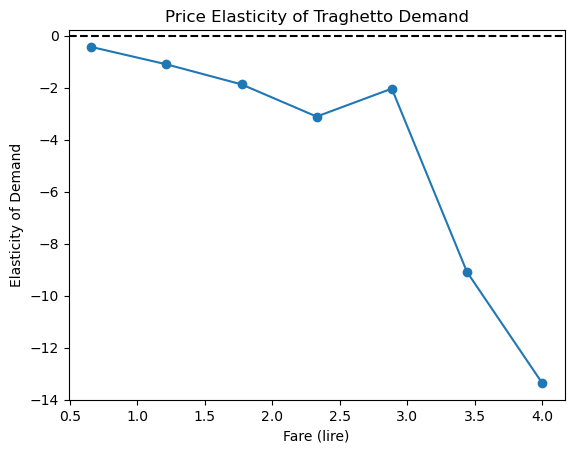

In [462]:
def compute_elasticity(df, capacity=500):
    d = df[df["capacity"] == capacity].sort_values("fare")
    fares = d["fare"].values
    demand = d["ue_demand"].values  # or "so_demand"
    elasticity = []
    for i in range(1, len(fares)):
        dq = demand[i] - demand[i-1]
        dp = fares[i] - fares[i-1]
        # Midpoint formula for arc elasticity
        avg_q = (demand[i] + demand[i-1]) / 2
        avg_p = (fares[i] + fares[i-1]) / 2
        E = (dq/avg_q) / (dp/avg_p)
        elasticity.append(E)
    return fares[1:], elasticity

# Usage
fare_pts, elas = compute_elasticity(results, capacity=500)
plt.plot(fare_pts, elas, marker='o')
plt.axhline(0, color='k', ls='--')
plt.xlabel("Fare (lire)")
plt.ylabel("Elasticity of Demand")
plt.title("Price Elasticity of Traghetto Demand")
plt.show()